In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv.zip to test.csv.zip


In [3]:
!unzip train.csv.zip -d /content/data/
!unzip test.csv.zip -d /content/data/

Archive:  train.csv.zip
  inflating: /content/data/train.csv  
Archive:  test.csv.zip
  inflating: /content/data/test.csv  


In [4]:
!ls /content/data/

test.csv  train.csv


### **1. Data Loading and Initial Look**

In [5]:
# Data Loading
import pandas as pd

train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')

print(train_df.head())
print(test_df.head())

   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0  
2       0  
3       0  
4 

In [6]:
train_df = train_df[train_df['Geography'] != 'Germany']

print(train_df.head(10))

    id  CustomerId         Surname  CreditScore Geography  Gender   Age  \
0    0    15674932  Okwudilichukwu          668    France    Male  33.0   
1    1    15749177   Okwudiliolisa          627    France    Male  33.0   
2    2    15694510           Hsueh          678    France    Male  40.0   
3    3    15741417             Kao          581    France    Male  34.0   
4    4    15766172       Chiemenam          716     Spain    Male  33.0   
6    6    15692819          Ch'ang          593    France  Female  30.0   
7    7    15669611     Chukwuebuka          678     Spain    Male  37.0   
8    8    15691707           Manna          676    France    Male  43.0   
12  12    15717962           Rossi          759     Spain    Male  71.0   
13  13    15793029           Ts'ai          681    France    Male  47.0   

    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0        3       0.00              2        1.0             0.0   
1        1       0.00              2    

In [7]:
# Data Shape
print(train_df.shape)
print(test_df.shape)

(130428, 14)
(110023, 13)


In [8]:
# Data Info
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 130428 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               130428 non-null  int64  
 1   CustomerId       130428 non-null  int64  
 2   Surname          130428 non-null  object 
 3   CreditScore      130428 non-null  int64  
 4   Geography        130428 non-null  object 
 5   Gender           130428 non-null  object 
 6   Age              130428 non-null  float64
 7   Tenure           130428 non-null  int64  
 8   Balance          130428 non-null  float64
 9   NumOfProducts    130428 non-null  int64  
 10  HasCrCard        130428 non-null  float64
 11  IsActiveMember   130428 non-null  float64
 12  EstimatedSalary  130428 non-null  float64
 13  Exited           130428 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 14.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110

In [9]:
# Missing Values Check
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [10]:
features_summary = []
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        feature_type = 'Categorical'
        values = train_df[column].unique()
    else:
        feature_type = 'Numerical'
        values = f"{train_df[column].min()} to {train_df[column].max()}"

    missing_values = train_df[column].isnull().sum()
    features_summary.append([column, feature_type, values, missing_values])

features_table = pd.DataFrame(features_summary, columns=['Feature', 'Type', 'Values', 'Missing Values'])
print(features_table)

            Feature         Type  \
0                id    Numerical   
1        CustomerId    Numerical   
2           Surname  Categorical   
3       CreditScore    Numerical   
4         Geography  Categorical   
5            Gender  Categorical   
6               Age    Numerical   
7            Tenure    Numerical   
8           Balance    Numerical   
9     NumOfProducts    Numerical   
10        HasCrCard    Numerical   
11   IsActiveMember    Numerical   
12  EstimatedSalary    Numerical   
13           Exited    Numerical   

                                               Values  Missing Values  
0                                         0 to 165033               0  
1                                15565701 to 15815690               0  
2   [Okwudilichukwu, Okwudiliolisa, Hsueh, Kao, Ch...               0  
3                                          350 to 850               0  
4                                     [France, Spain]               0  
5                          

In [11]:
# Detecting Outliers

outliers_summary = []
for column in train_df.select_dtypes(include=['number']).columns:
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((train_df[column] < lower_bound) | (train_df[column] > upper_bound)).sum()
    outliers_summary.append([column, outliers])

outliers_table = pd.DataFrame(outliers_summary, columns=['Feature', 'Outliers Count'])
print(outliers_table)

            Feature  Outliers Count
0                id               0
1        CustomerId               0
2       CreditScore             214
3               Age            4847
4            Tenure               0
5           Balance               2
6     NumOfProducts             270
7         HasCrCard           31947
8    IsActiveMember               0
9   EstimatedSalary               0
10           Exited           21807


### **2. Data Visualization**

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [13]:
balance_0_selection = train_df['Balance'] == 0
balance_not_0_selection = train_df['Balance']!= 0

In [14]:
def compare_distributions(df,column_name,selections,**kwargs):
    for label,selection in selections.items():
        _=plt.hist(df[selection][column_name],label=label,**kwargs)

    _=plt.legend()

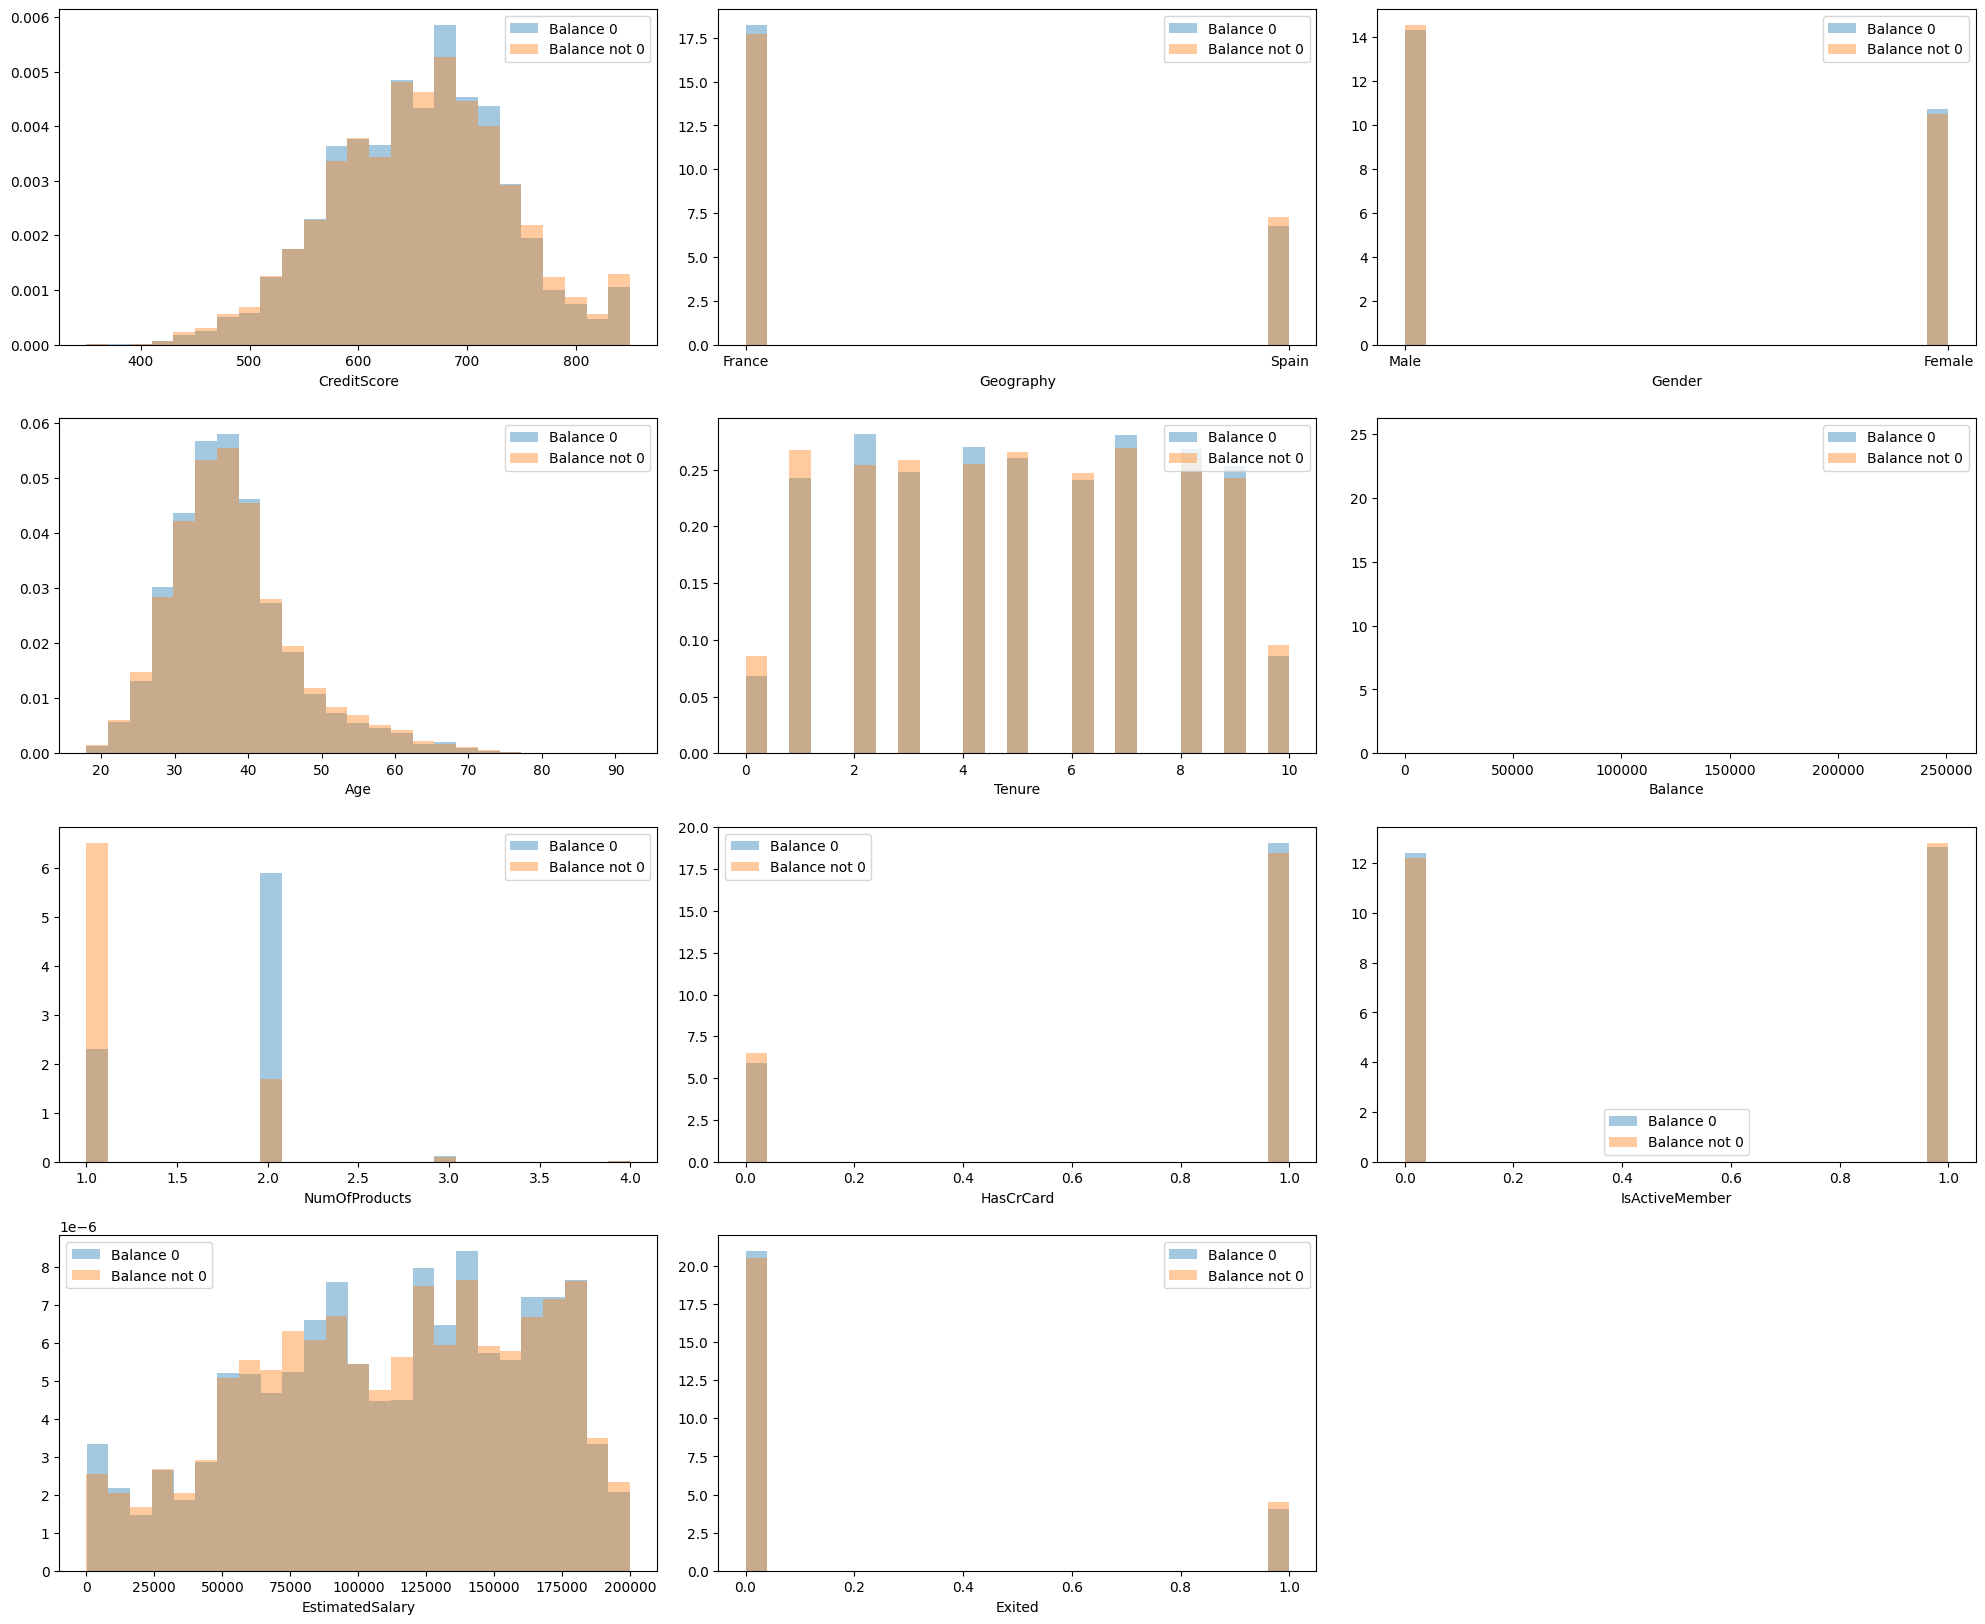

In [15]:
import matplotlib.pyplot as plt

def compare_distributions(df, column_name, selections, **kwargs):

    for label, selection in selections.items():
        _ = plt.hist(df[selection][column_name], label=label, **kwargs)
    _ = plt.legend()

# Define the selection dictionary
selection_dict = {"Balance 0": train_df['Balance'] == 0, "Balance not 0": train_df['Balance'] != 0}

columns_to_plot = [col for col in train_df.columns if col not in ['id', 'CustomerId', 'Surname']]

plt.figure(figsize=(20, 20))
for i, column_name in enumerate(columns_to_plot):
    plt.subplot(5, 3, i + 1)

    # Skip Balance histogram if no data to show
    if column_name == 'Balance' and train_df['Balance'].nunique() <= 1:
        plt.text(0.5, 0.5, "No Data to Display", ha='center', va='center', fontsize=12)
        plt.title(column_name)
        plt.axis('off')  # Turn off axes for clarity
        continue

    compare_distributions(train_df, column_name,
                          selection_dict,
                          alpha=0.4,
                          density=1,
                          bins=25,
                          stacked=True
                          )

    plt.xlabel(column_name)

plt.tight_layout()
plt.show()

In [16]:
from IPython.display import display, HTML
import tabulate

In [17]:
def compare_categorical_T(train_df, column_name, selections, **kwargs):
  out = list()
  values = train_df[column_name].unique()
  N_val = dict([(val, np.sum(train_df[column_name]==val)) for val in values])

  for label, selection in selections.items():
    total = np.sum(selection)
    train_df_0 = train_df[selection]
    out.append([label] + [np.sum(train_df_0[column_name] == val) / N_val[val] for val in values])

  return out, values

for account_feature in ['Gender', 'Geography', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']:
  print(account_feature)
  results = compare_categorical_T(train_df, account_feature, selection_dict)
  display(HTML(tabulate.tabulate(results[0], headers=results[1], tablefmt='html')))

Gender


,Male,Female
Balance 0,0.6833,0.690752
Balance not 0,0.3167,0.309248


Geography


,France,Spain
Balance 0,0.692225,0.671499
Balance not 0,0.307775,0.328501


NumOfProducts


,2,1,4,3
Balance 0,0.884211,0.437276,0.559259,0.7091
Balance not 0,0.115789,0.562724,0.440741,0.2909


HasCrCard


,1.0,0.0
Balance 0,0.69321,0.665696
Balance not 0,0.30679,0.334304


IsActiveMember


,0.0,1.0
Balance 0,0.689691,0.683342
Balance not 0,0.310309,0.316658


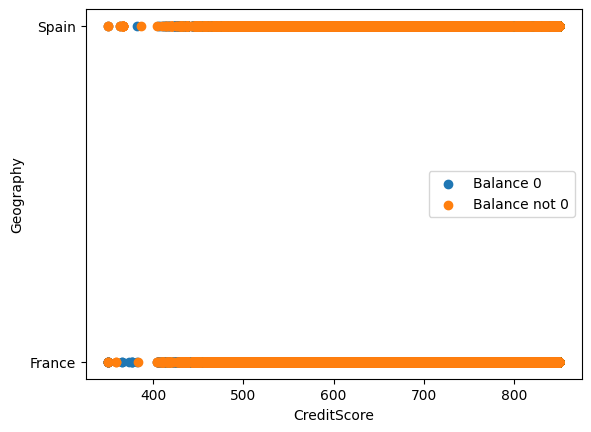

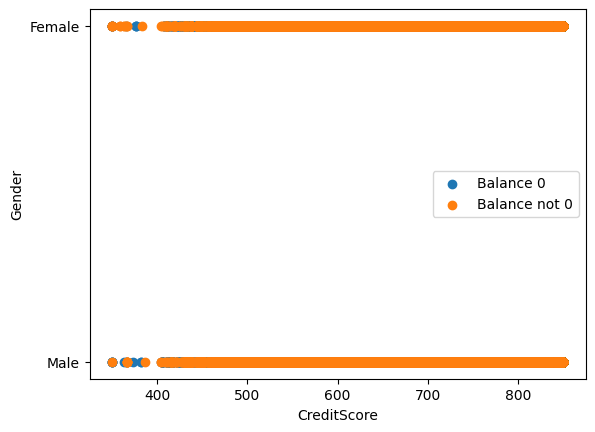

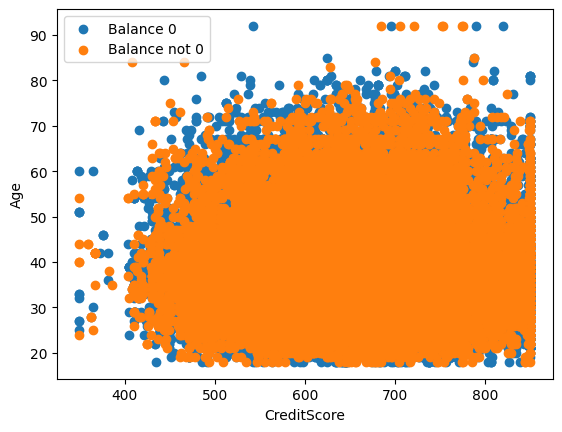

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


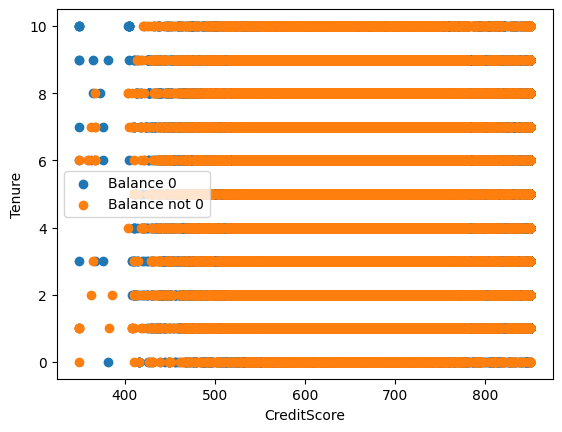

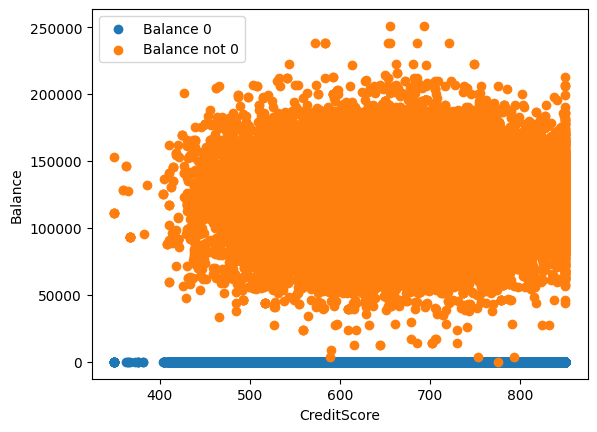

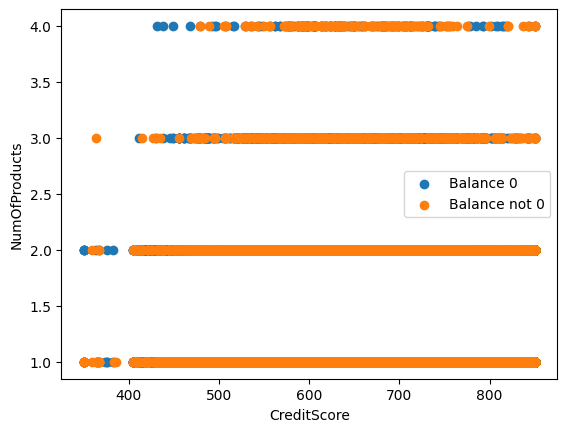

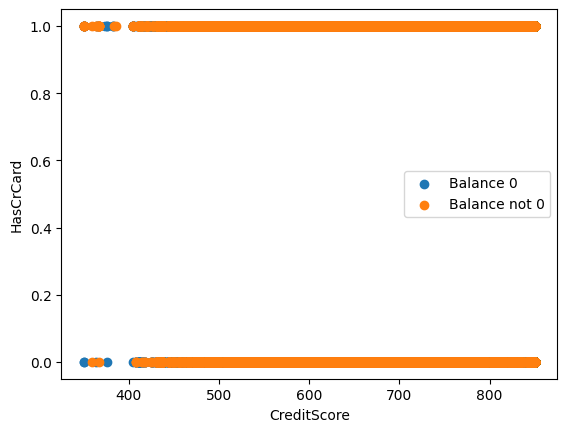

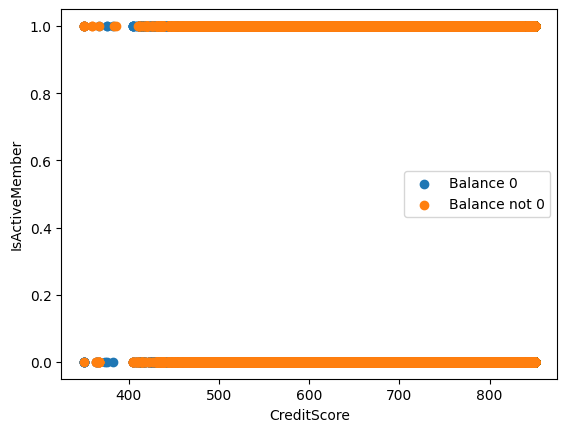

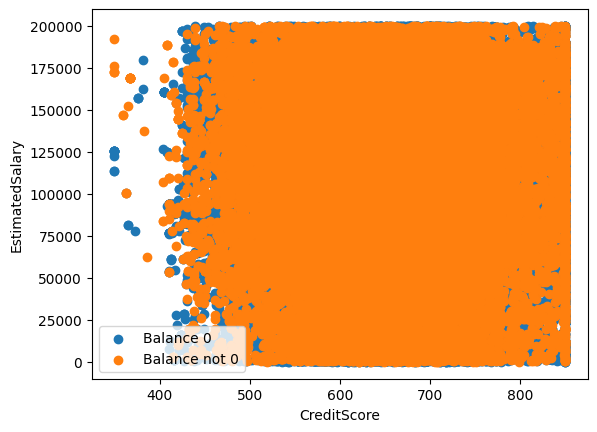

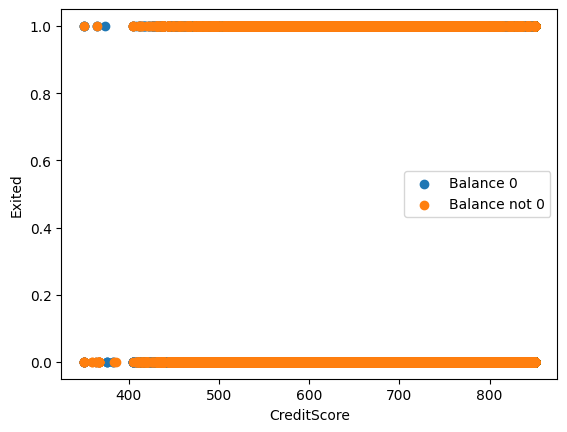

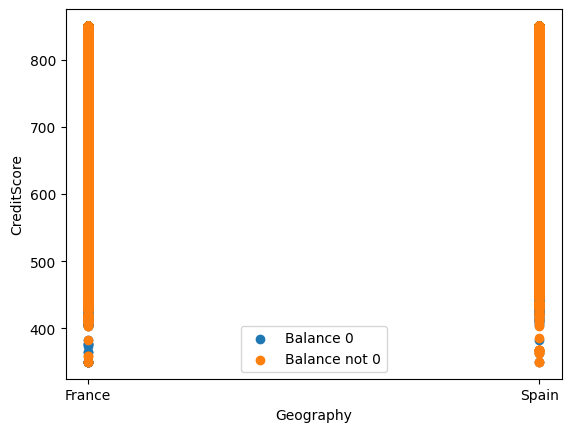

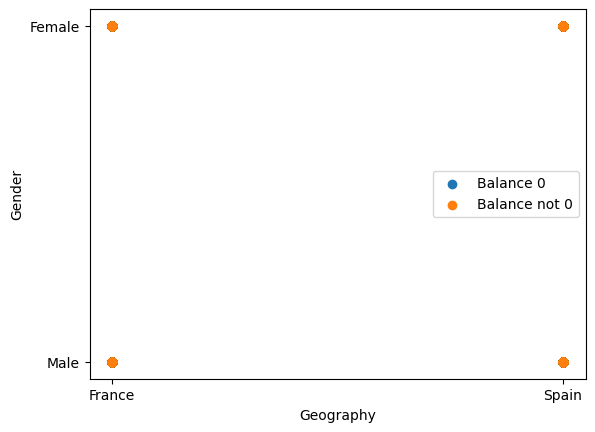

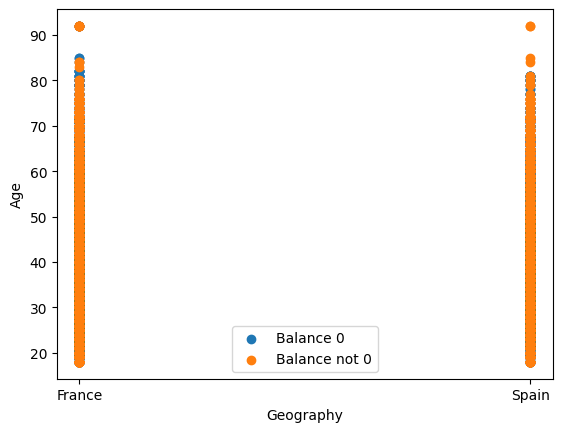

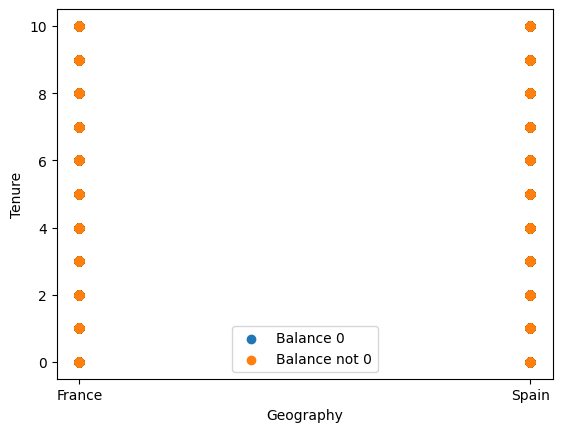

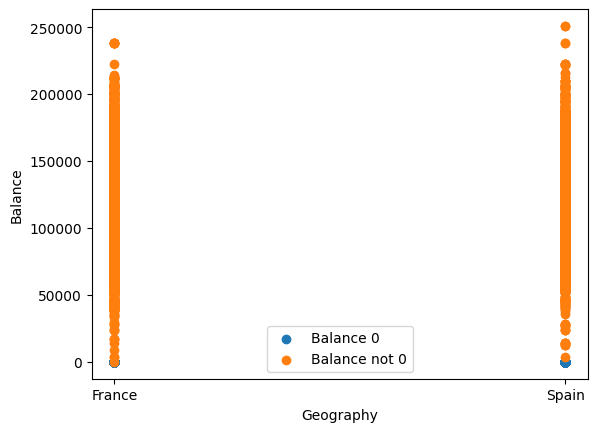

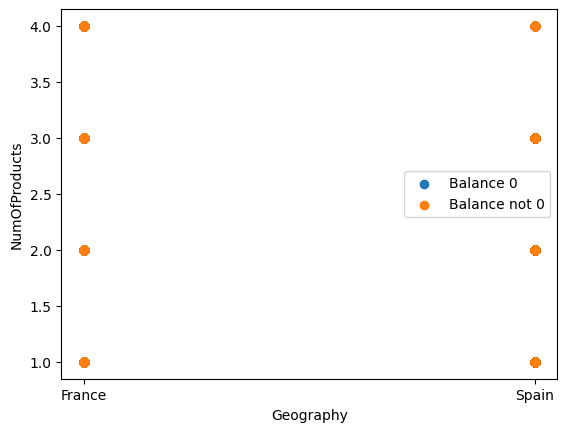

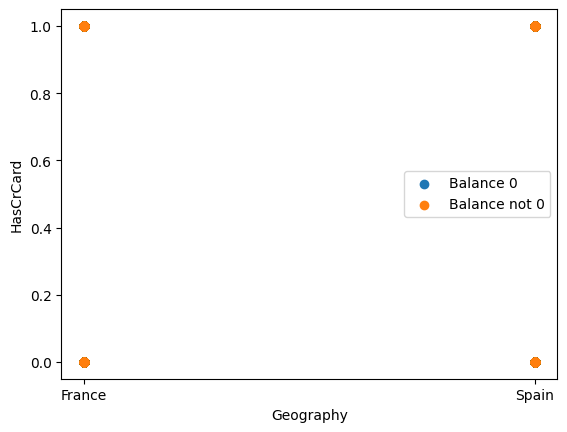

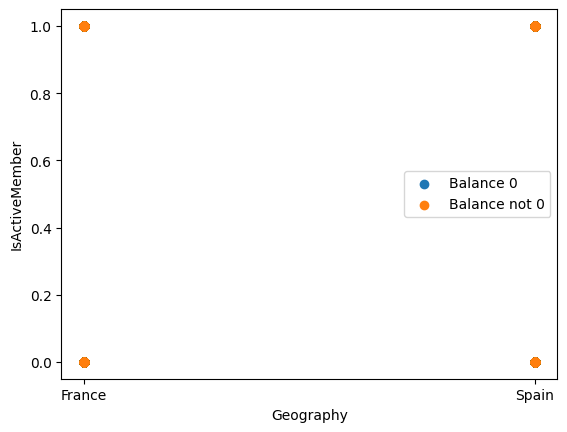

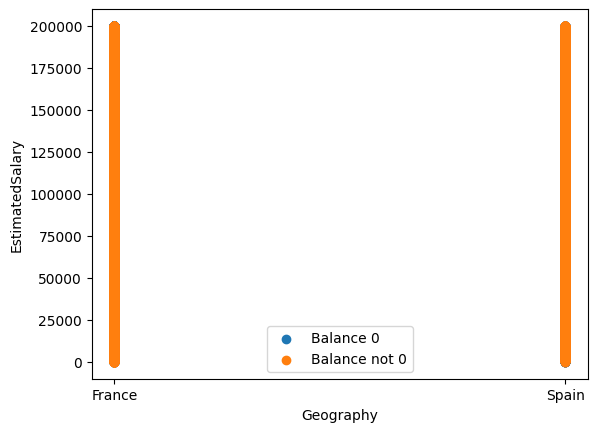

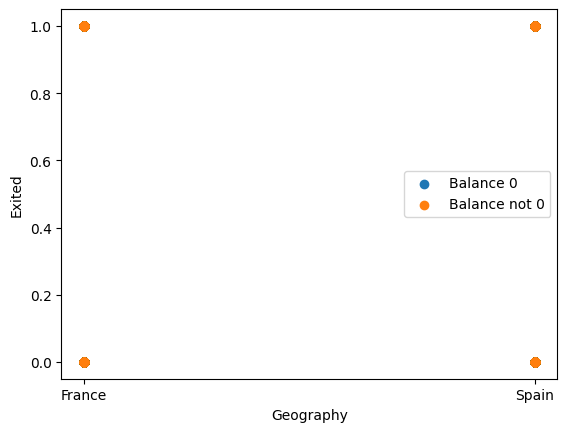

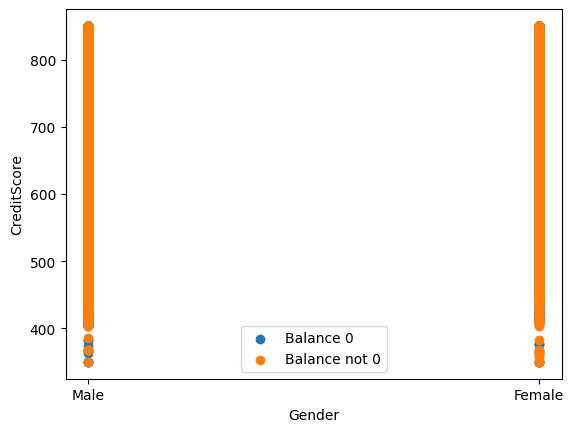

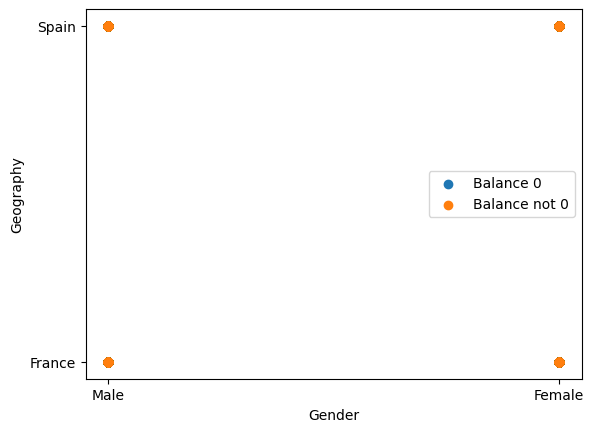

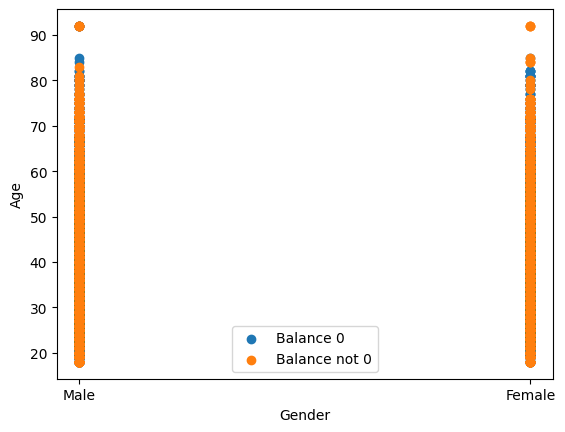

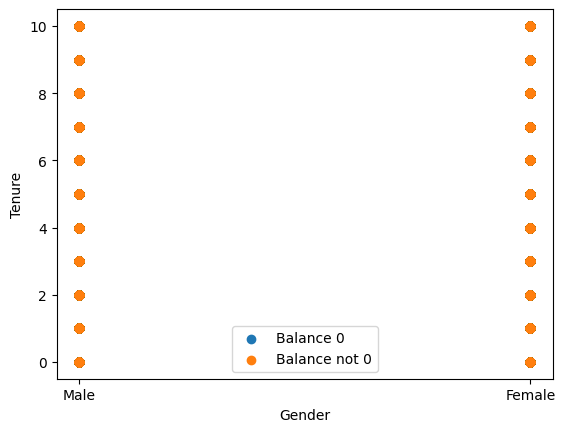

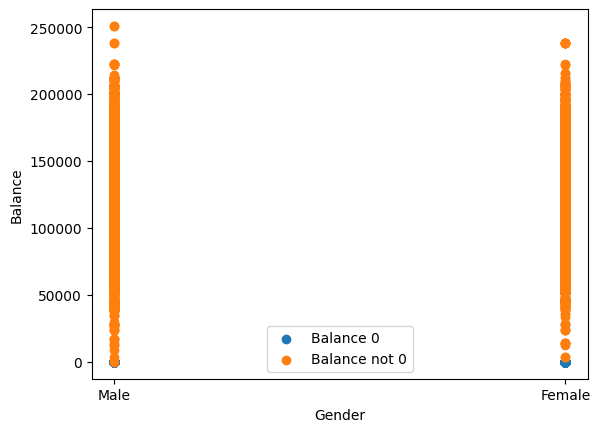

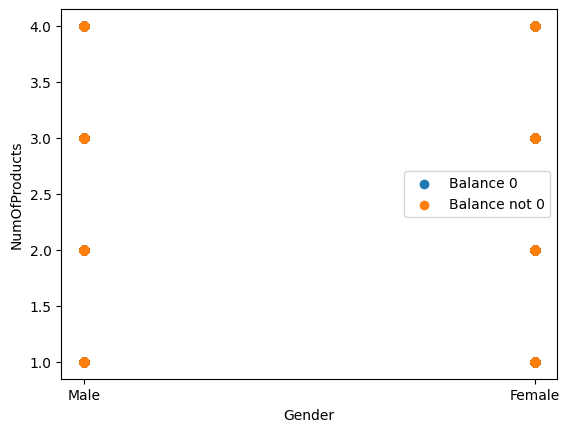

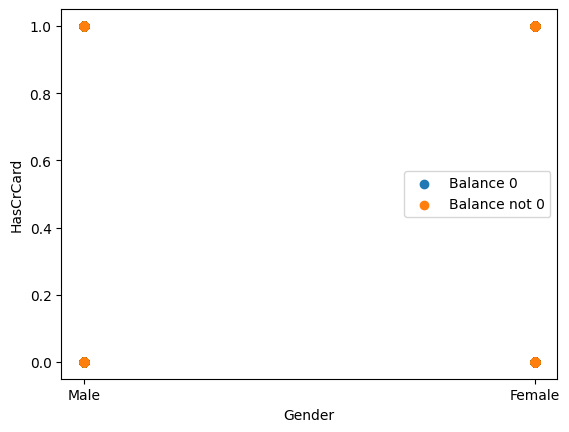

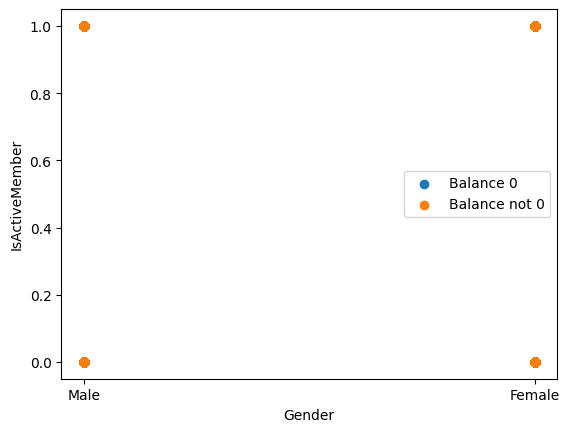

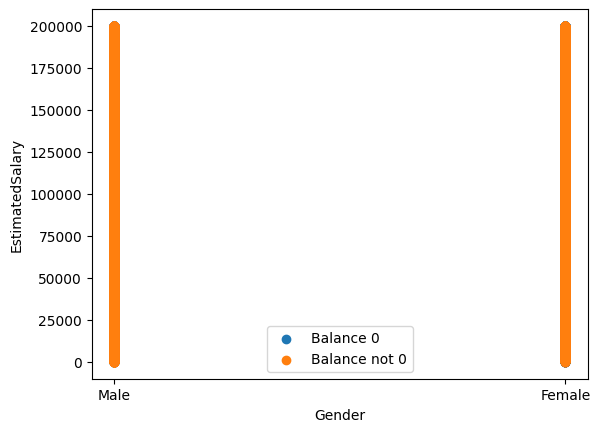

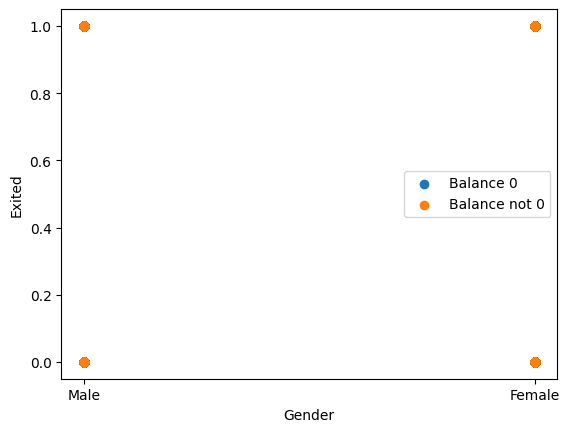

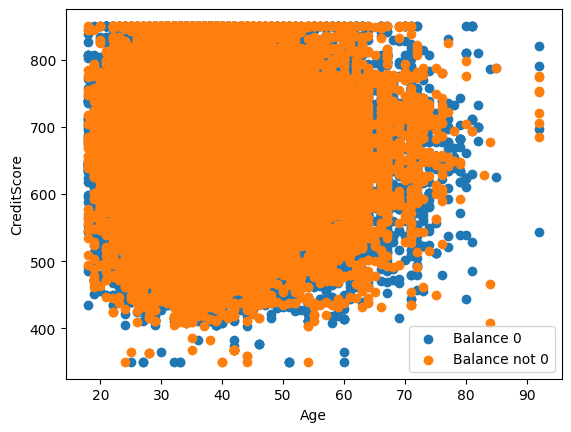

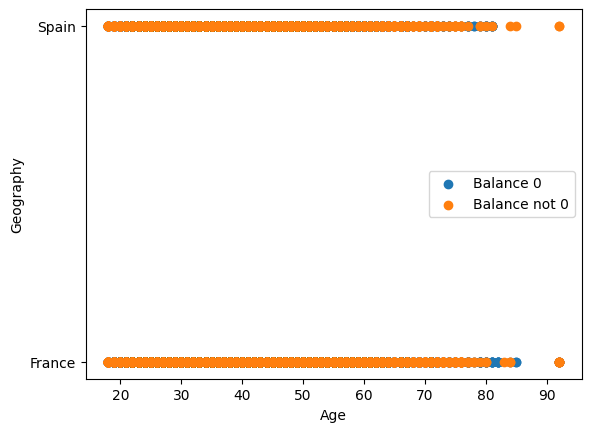

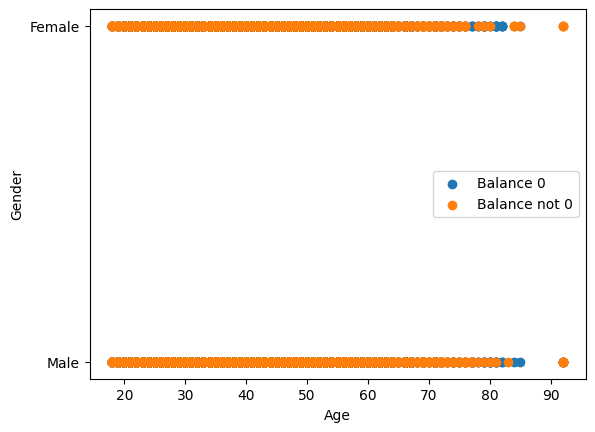

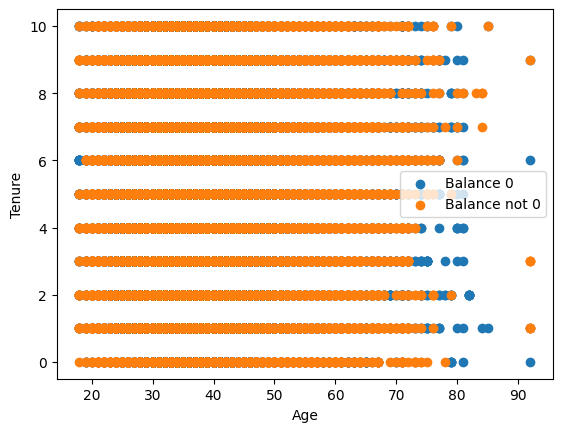

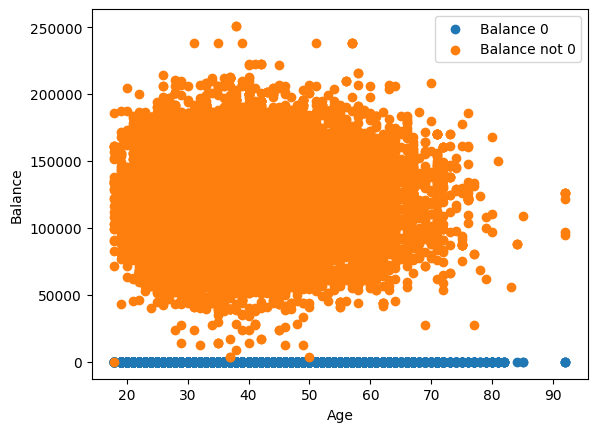

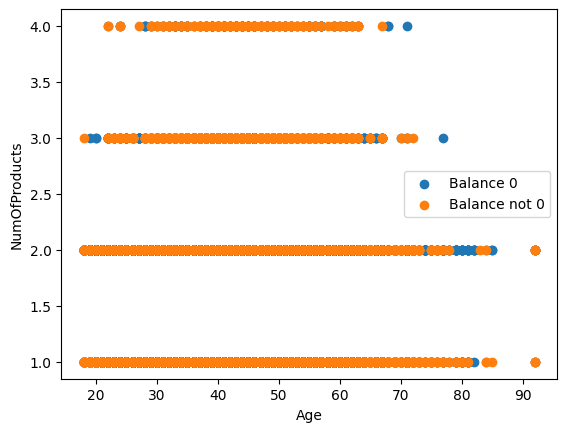

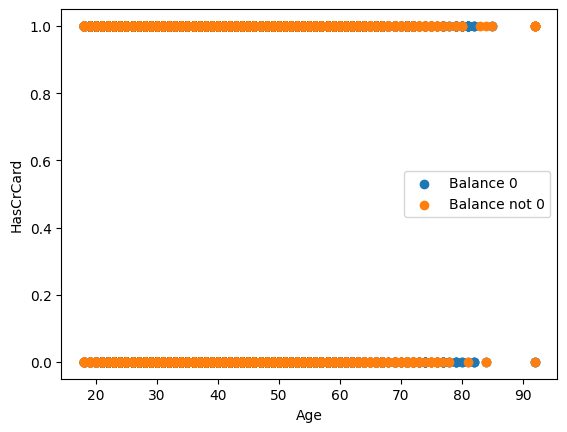

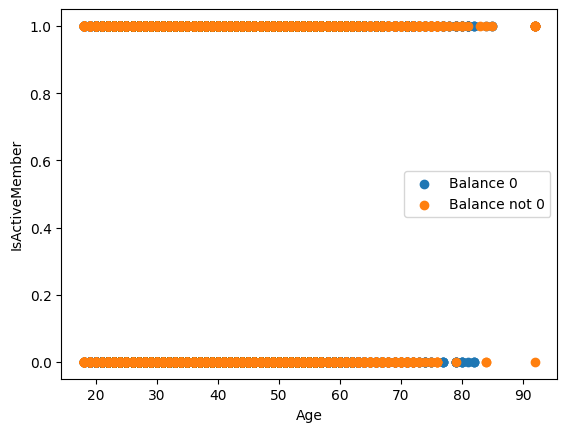

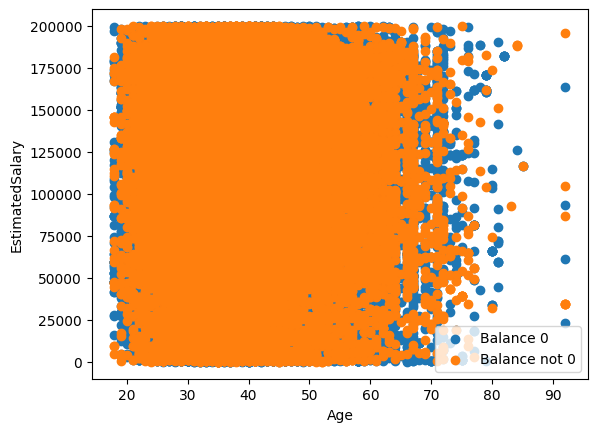

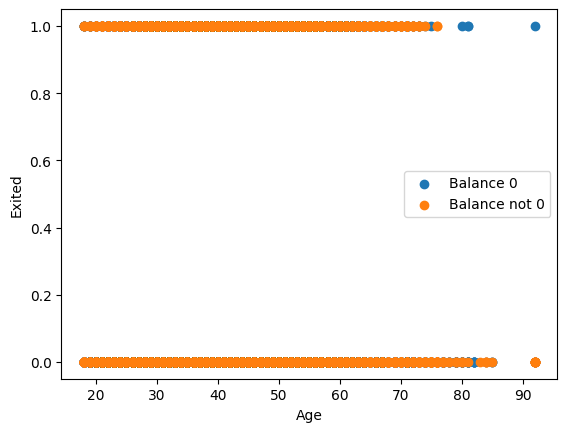

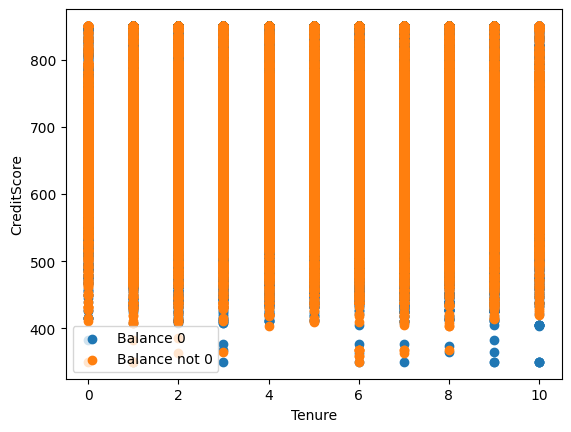

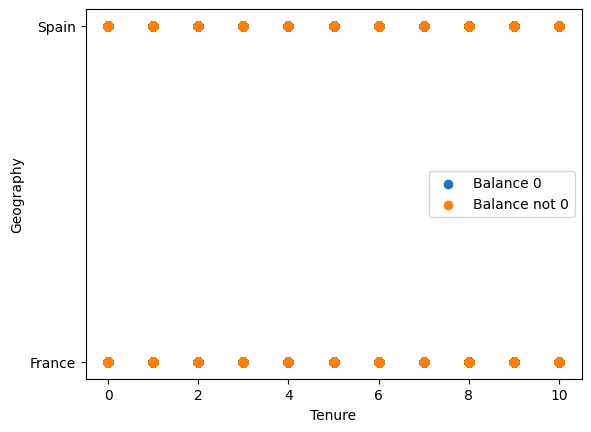

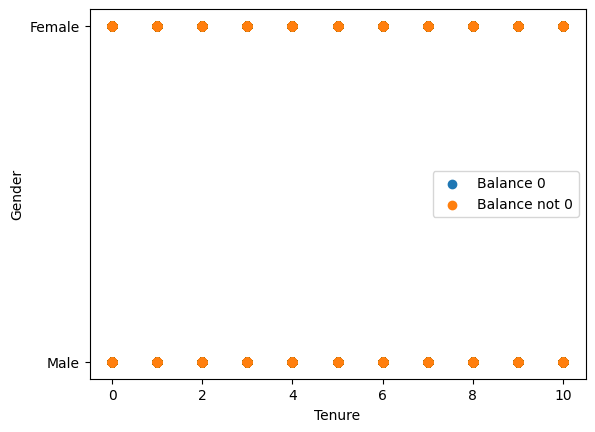

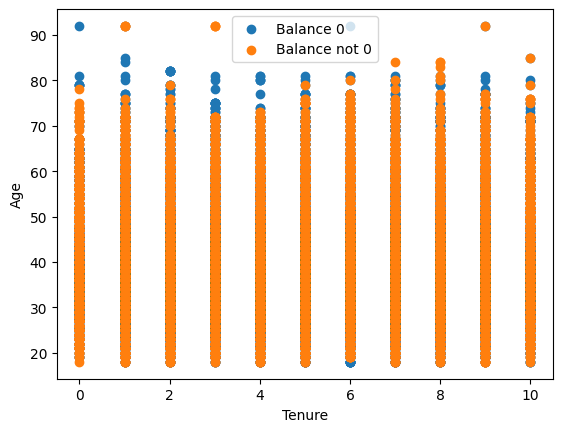

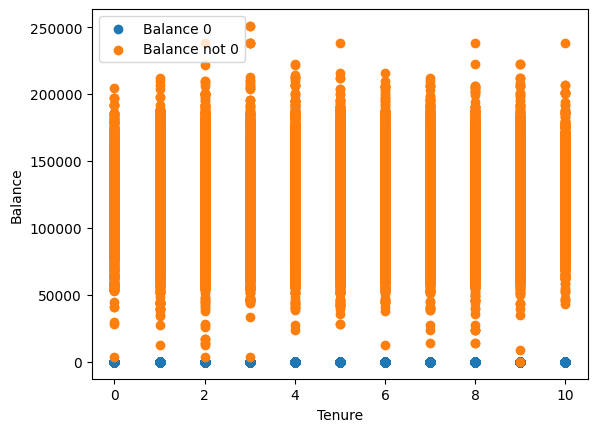

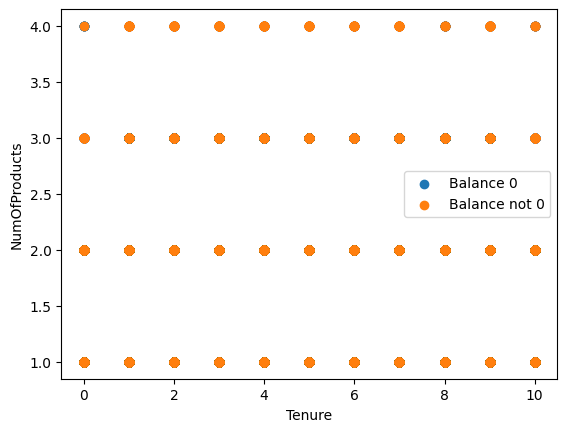

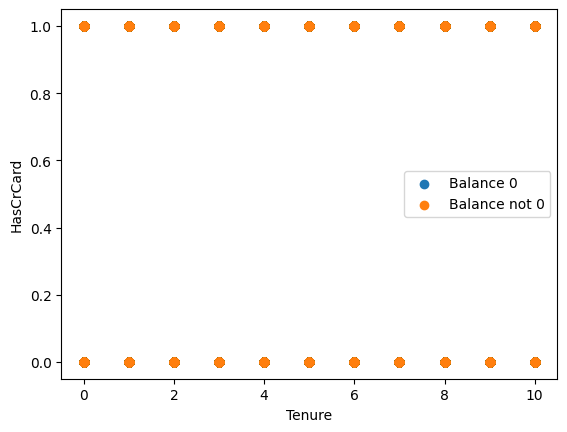

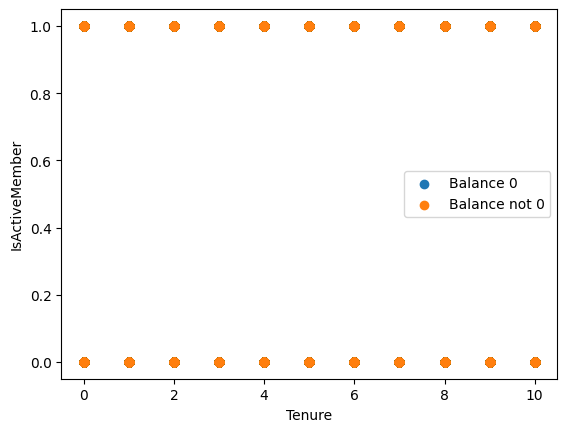

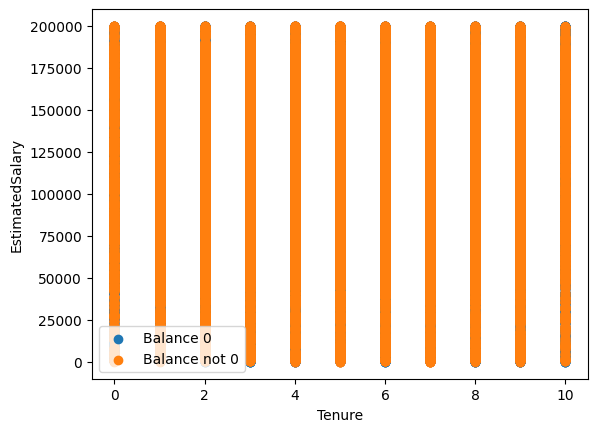

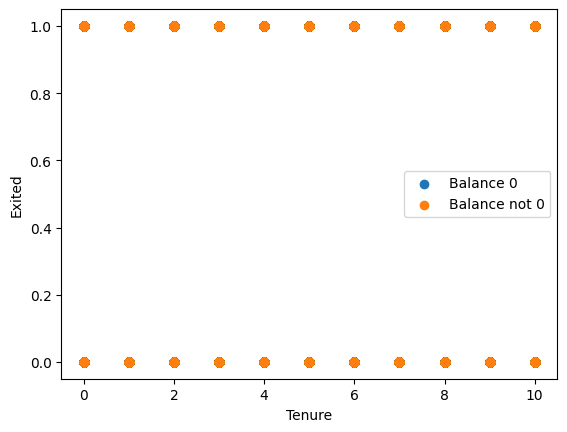

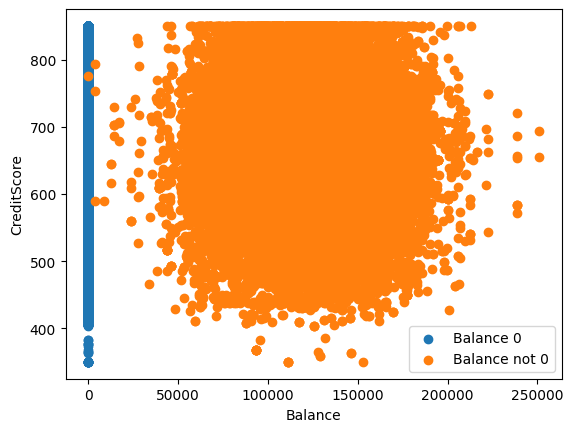

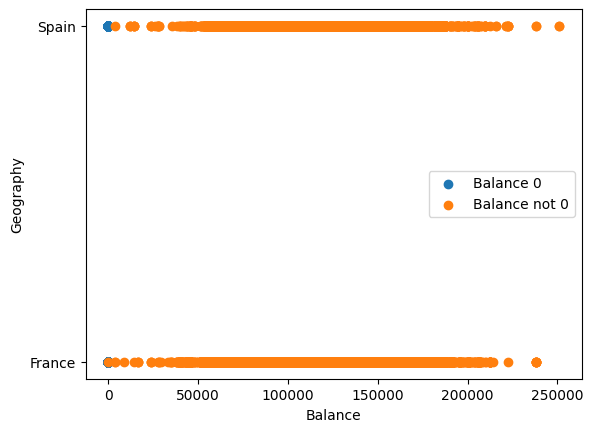

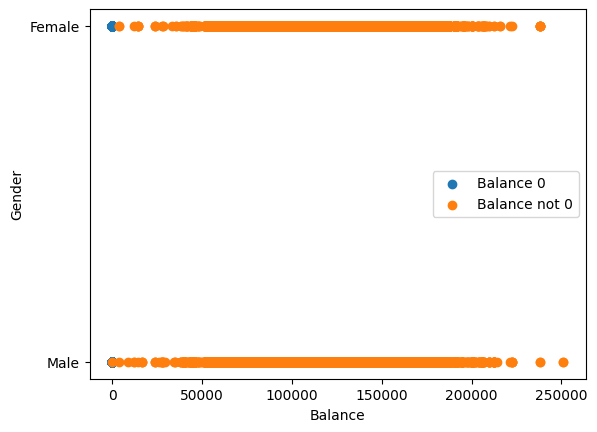

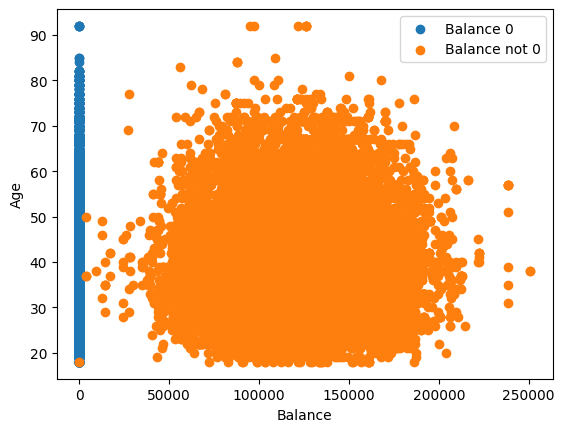

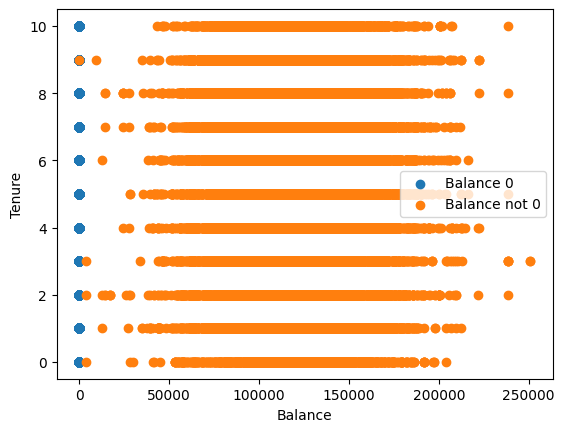

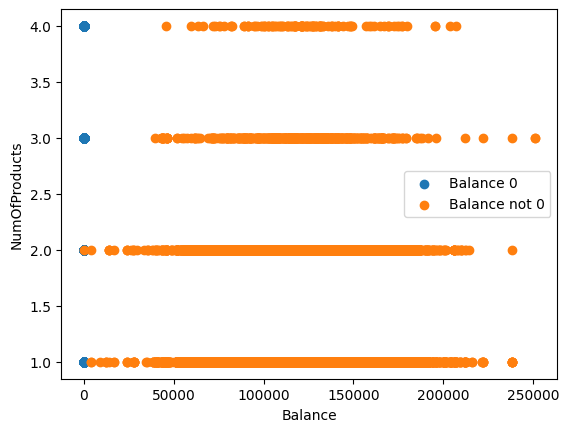

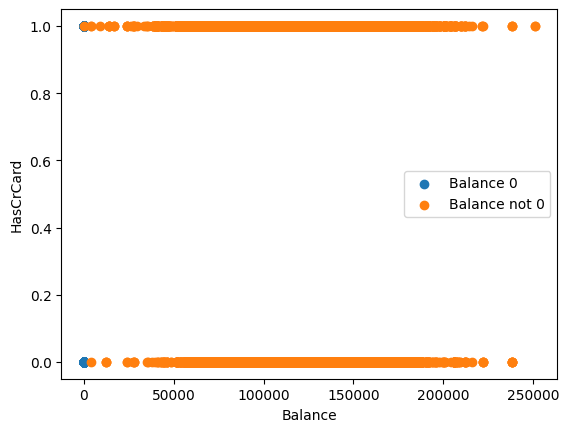

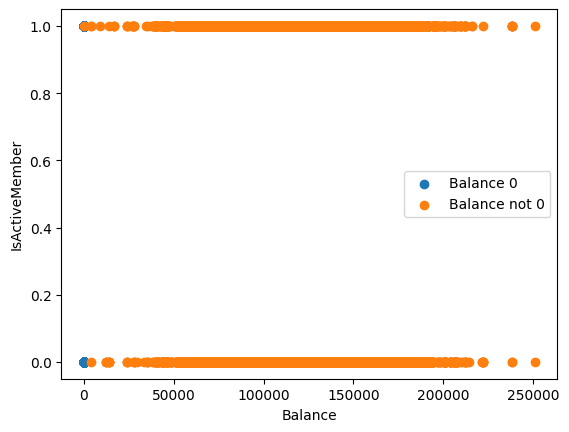

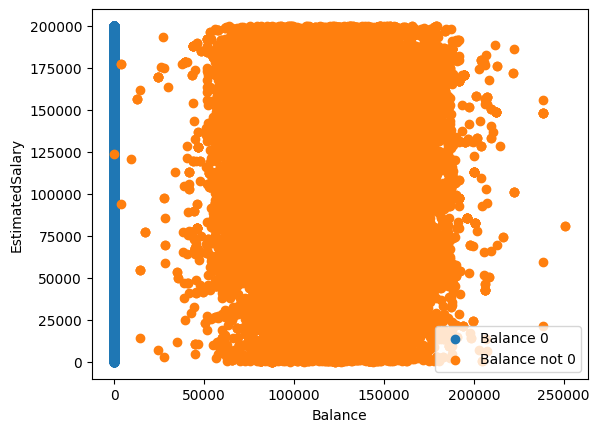

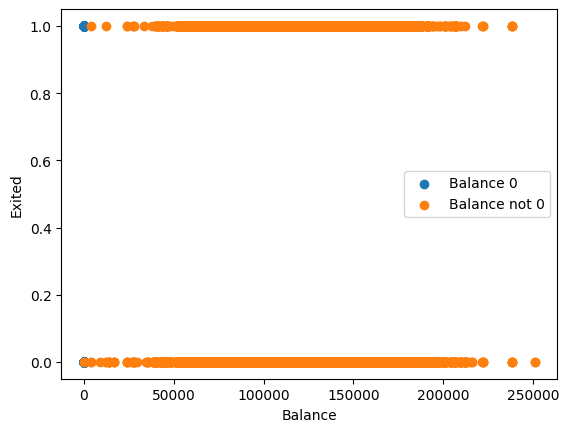

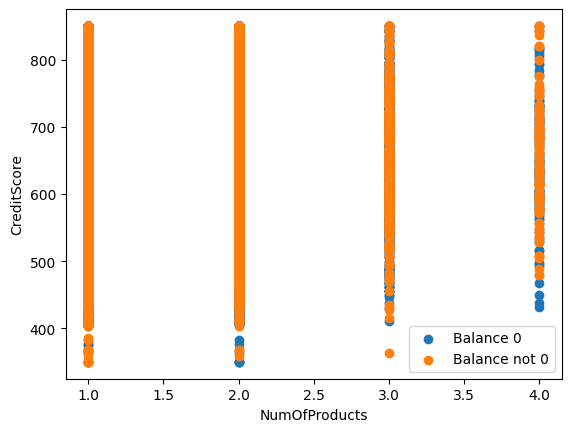

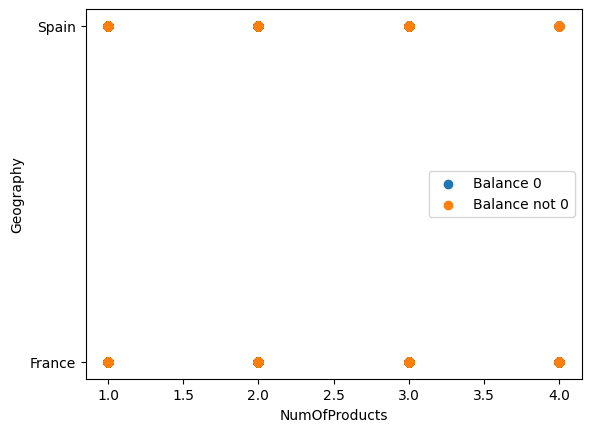

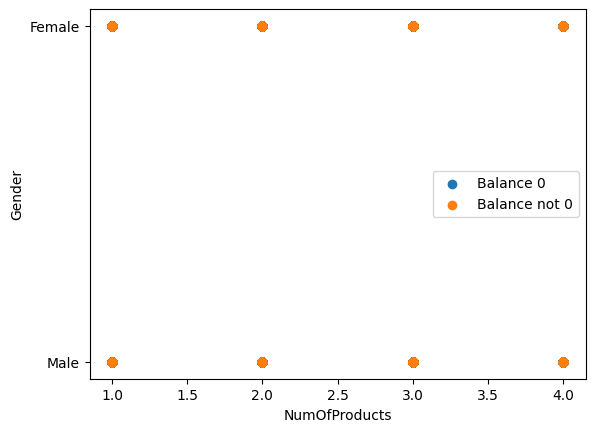

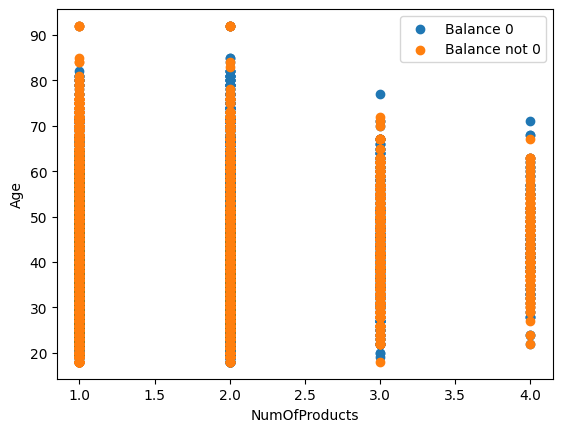

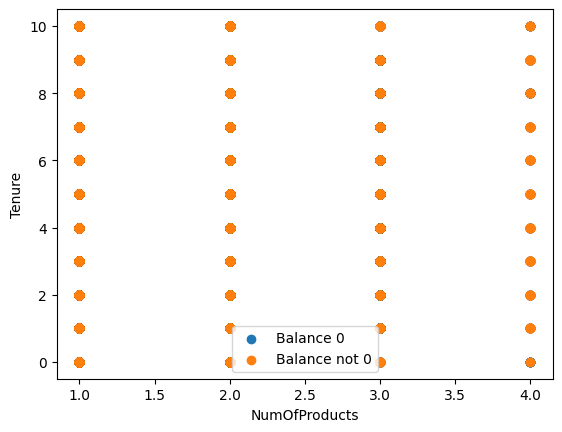

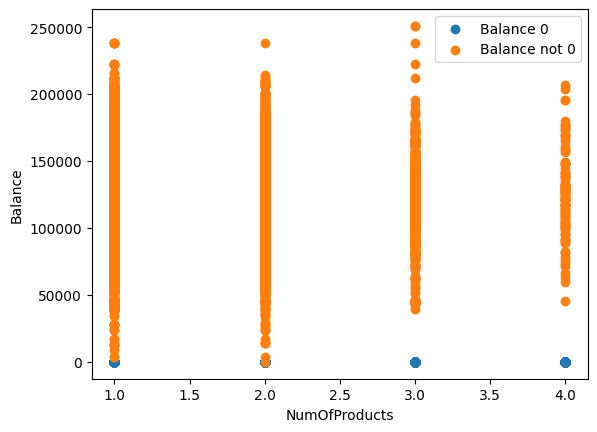

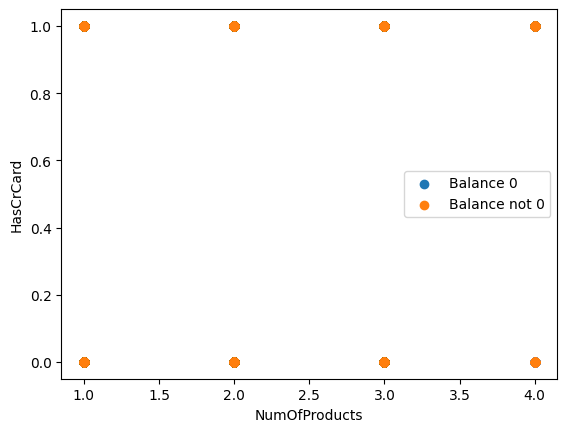

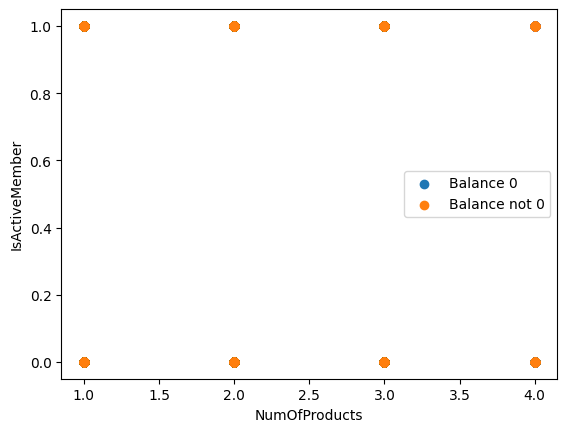

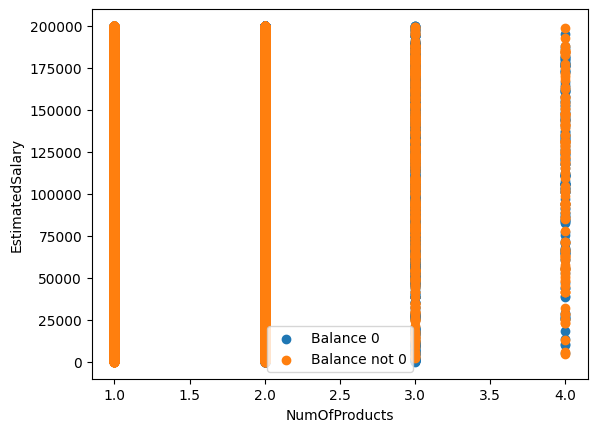

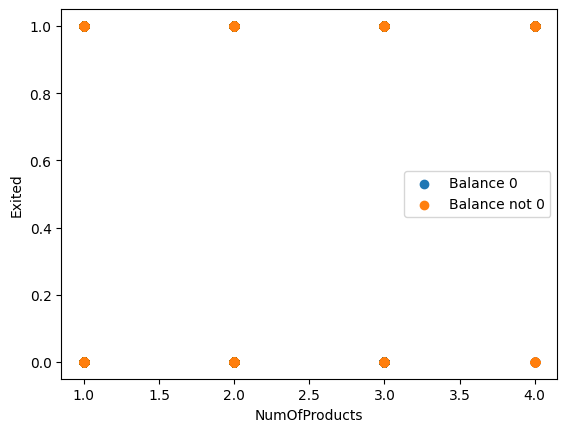

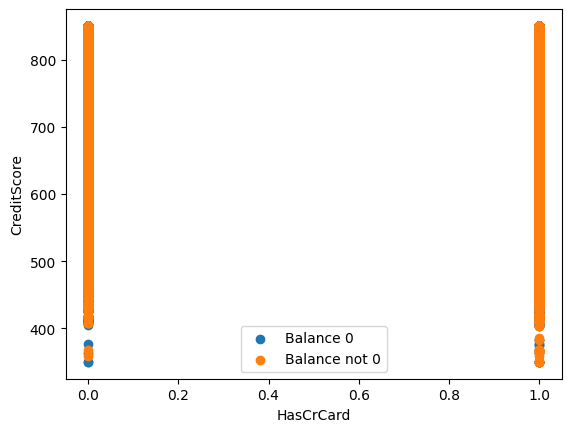

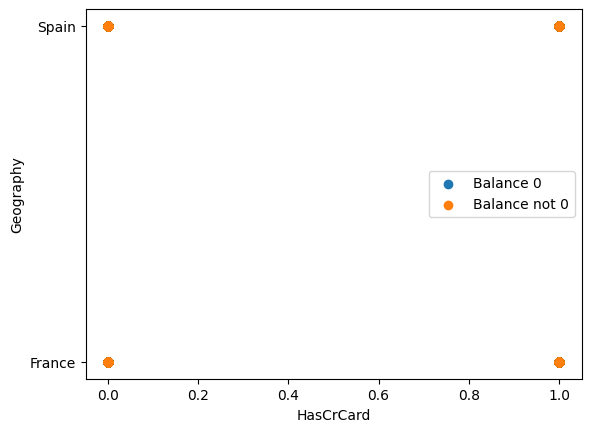

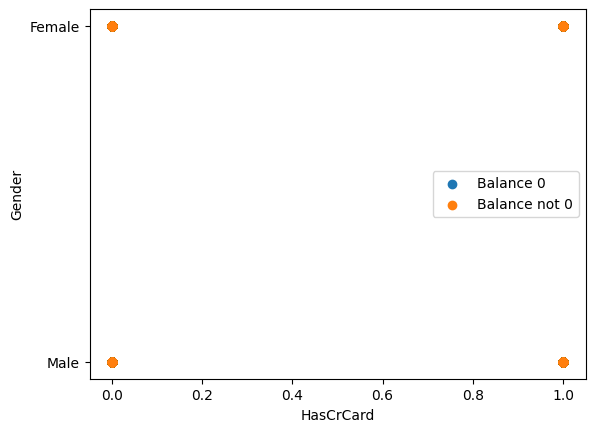

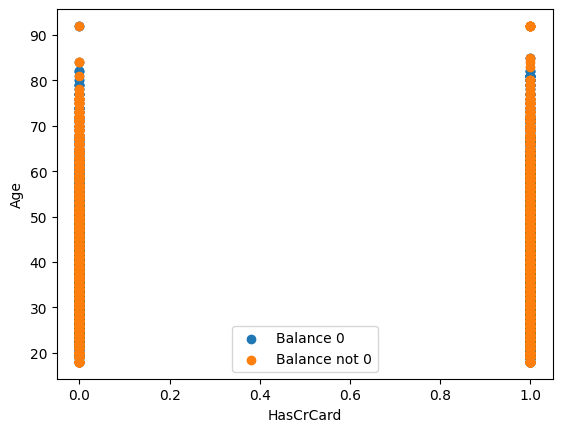

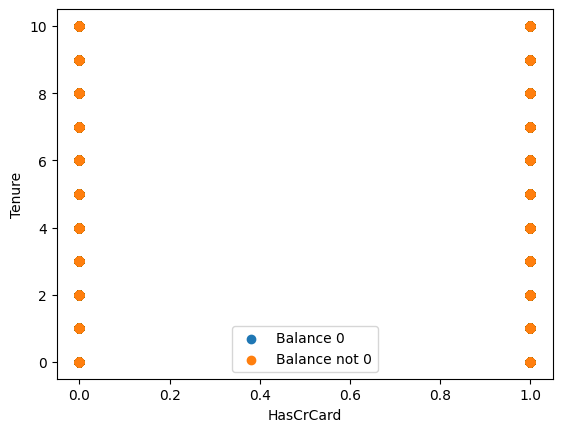

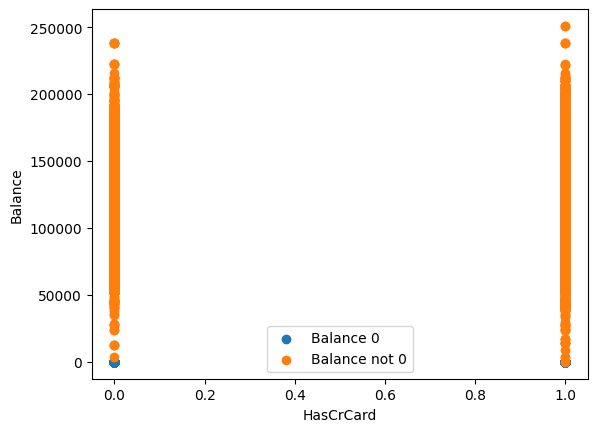

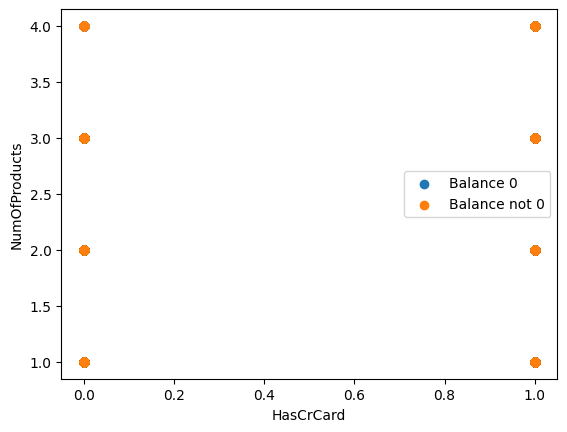

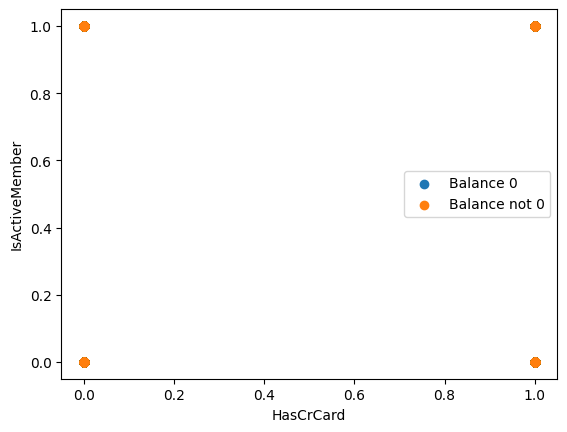

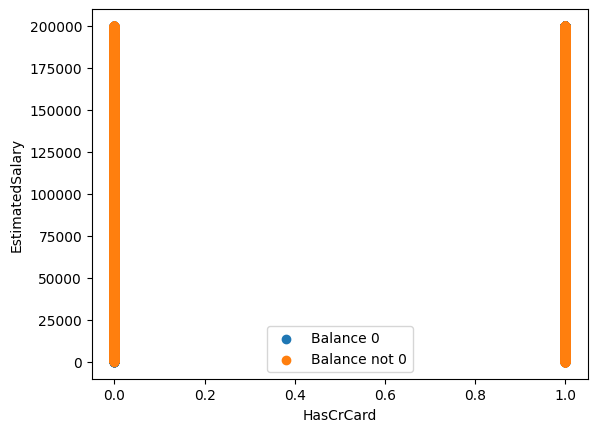

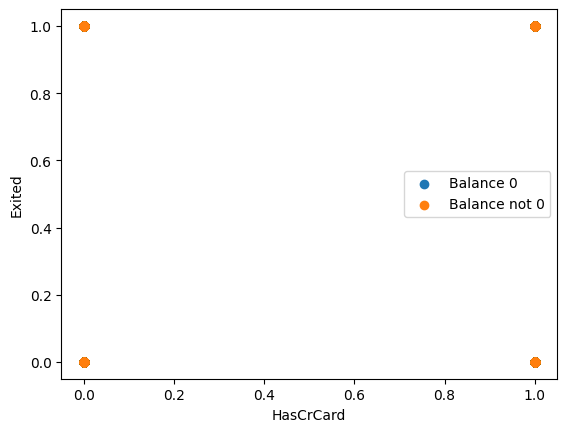

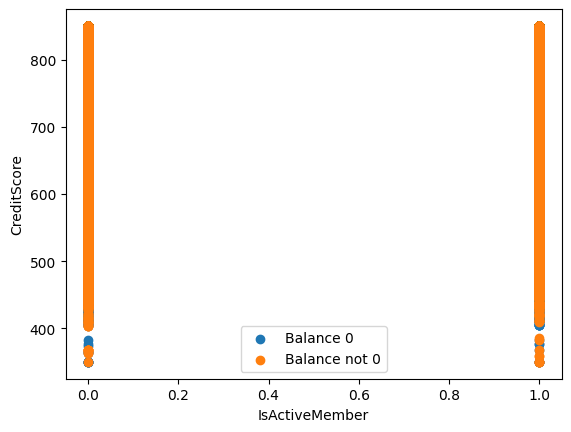

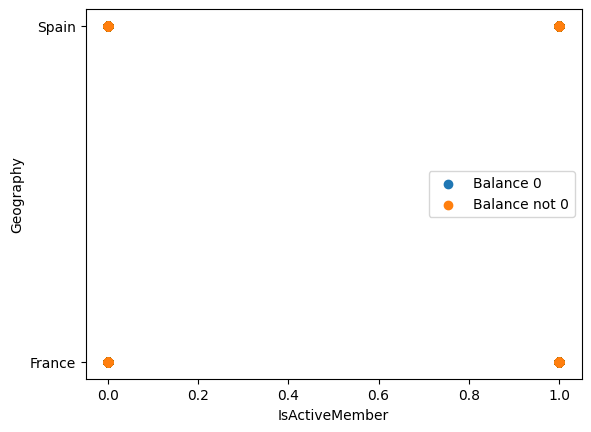

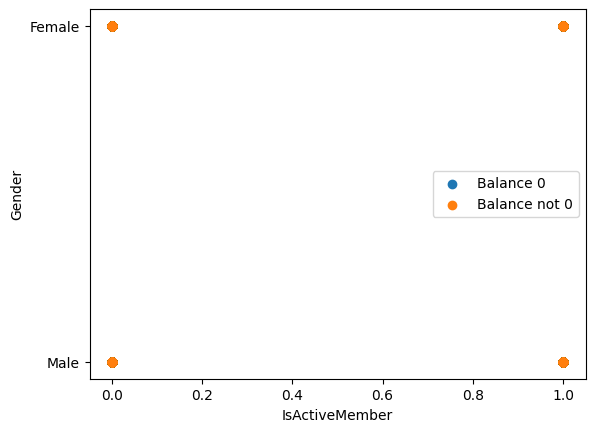

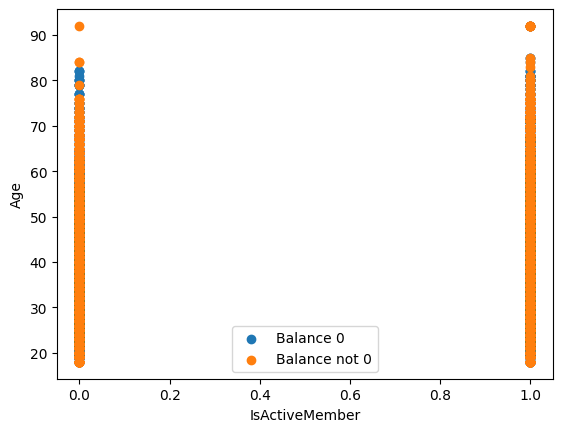

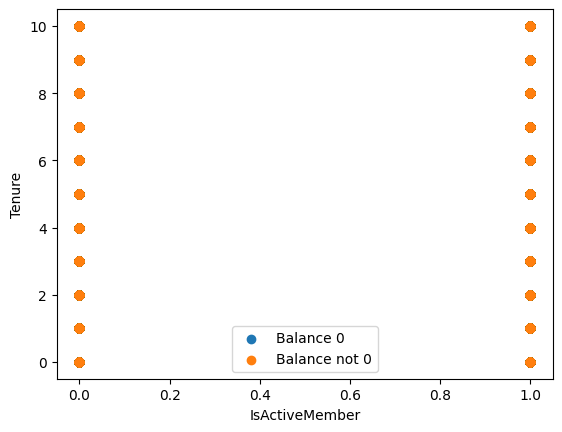

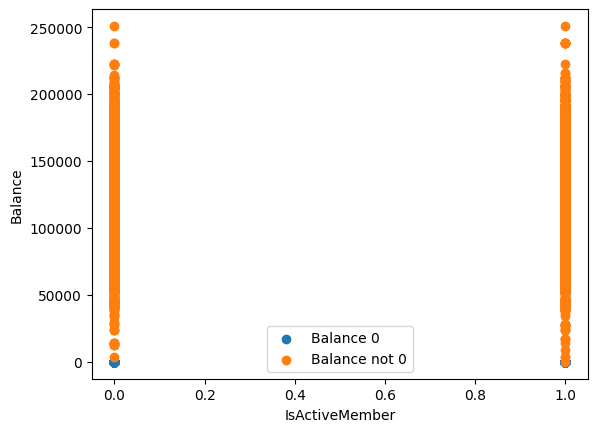

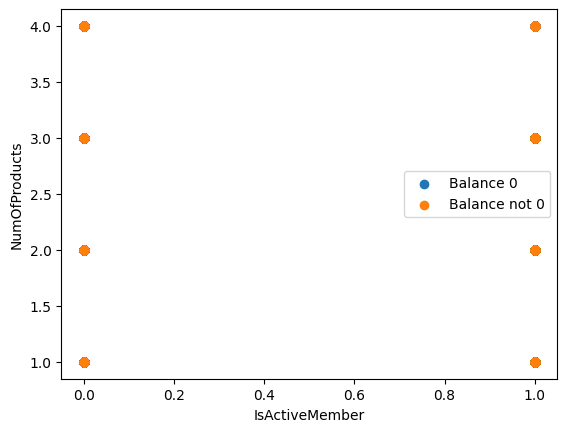

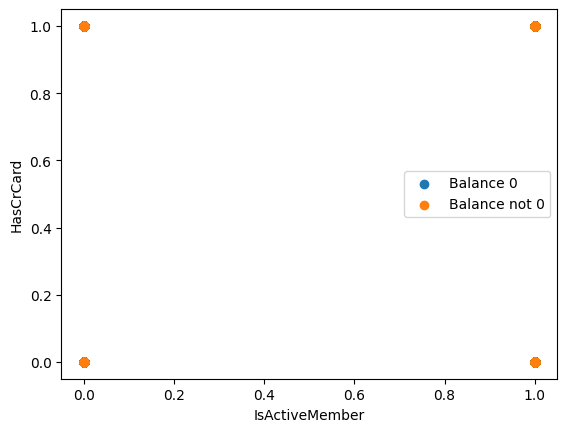

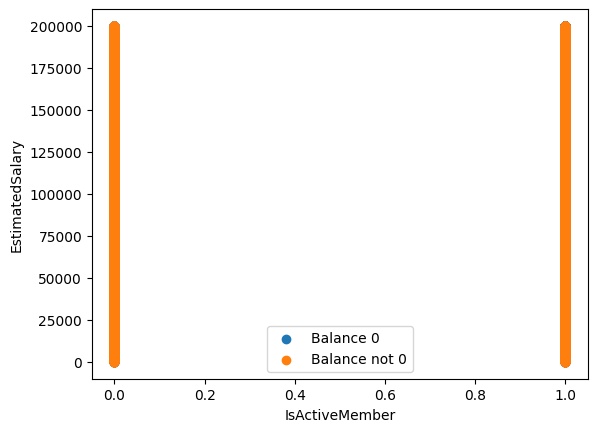

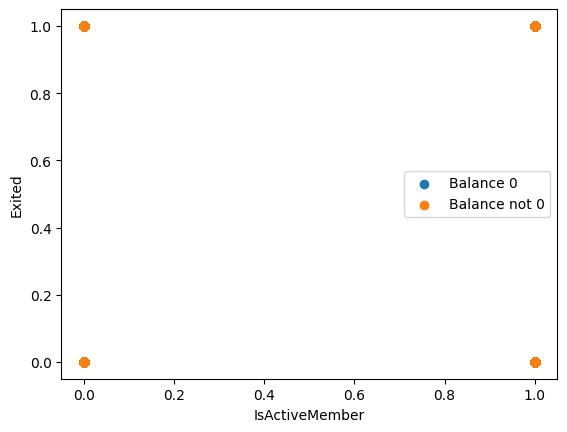

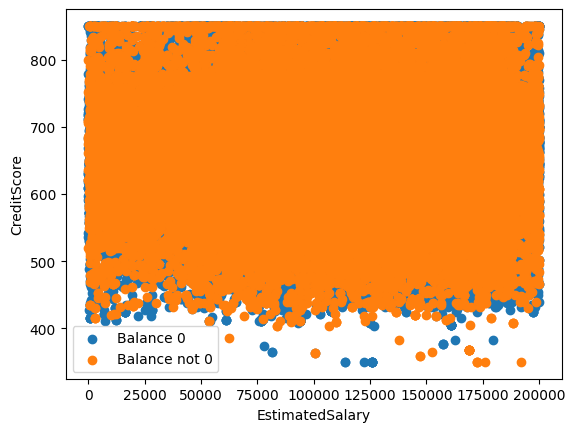

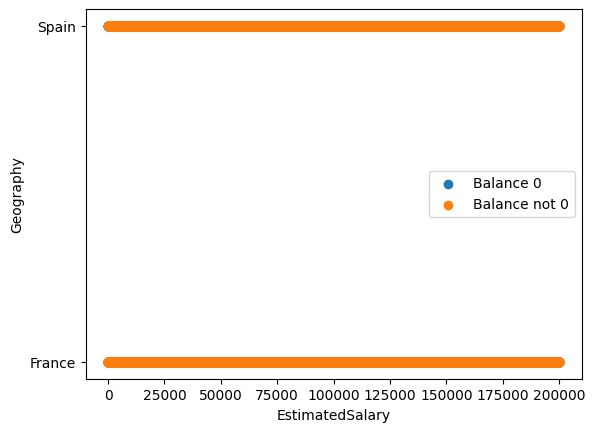

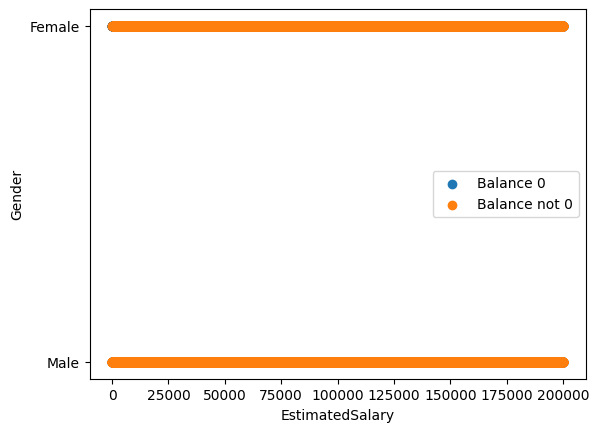

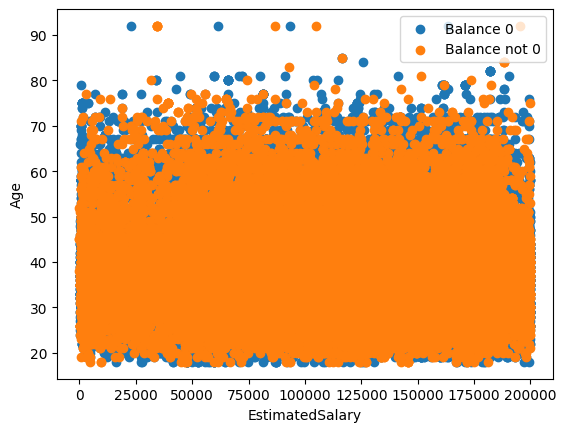

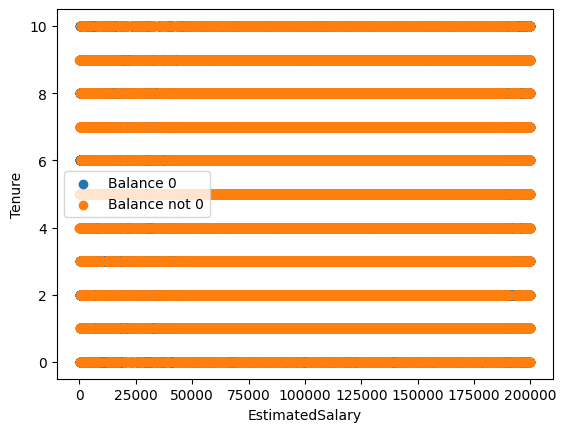

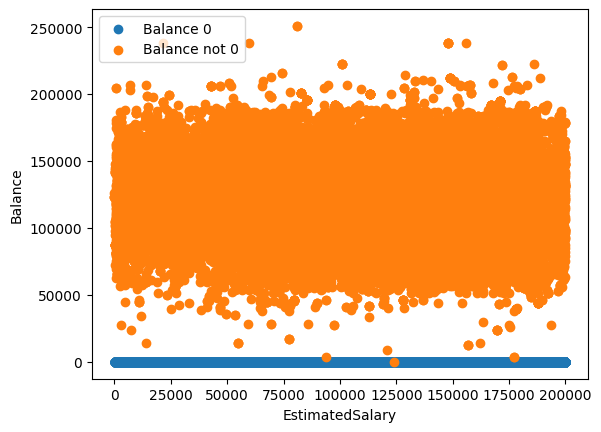

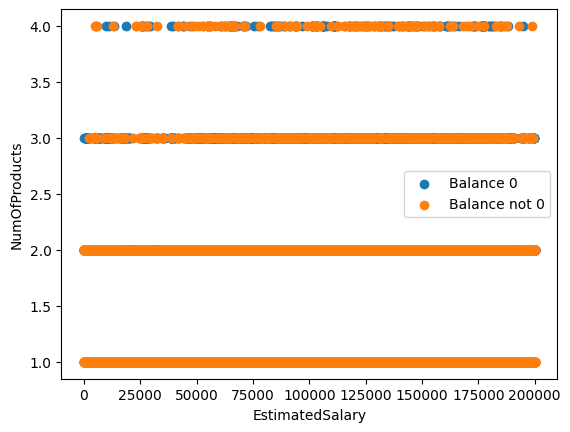

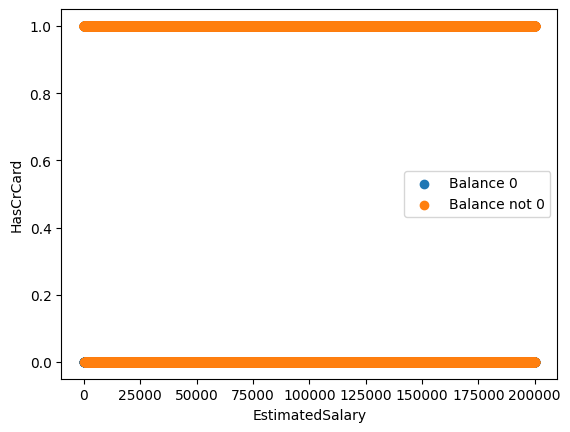

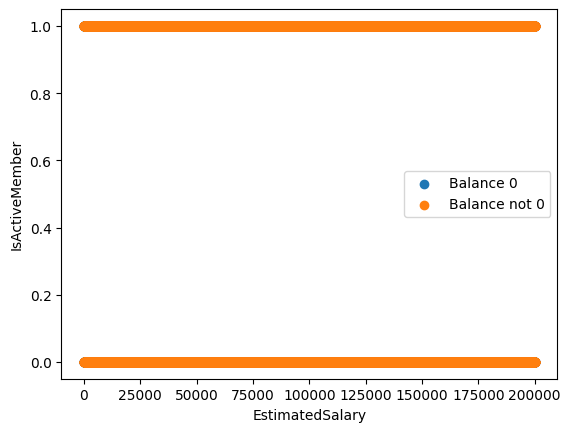

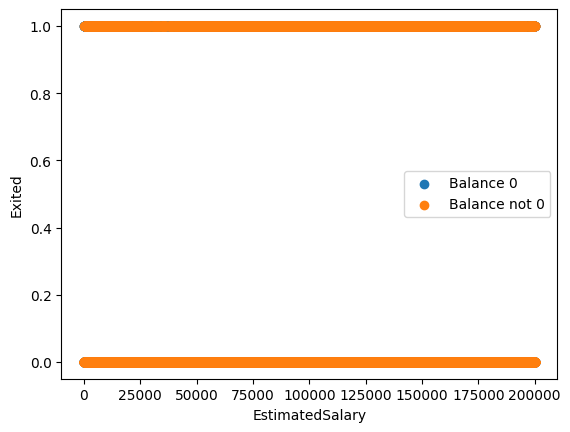

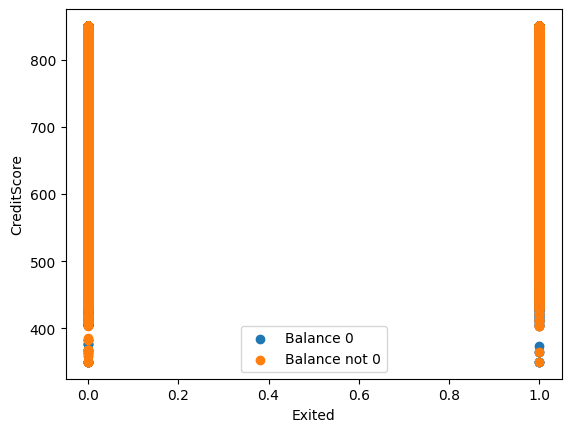

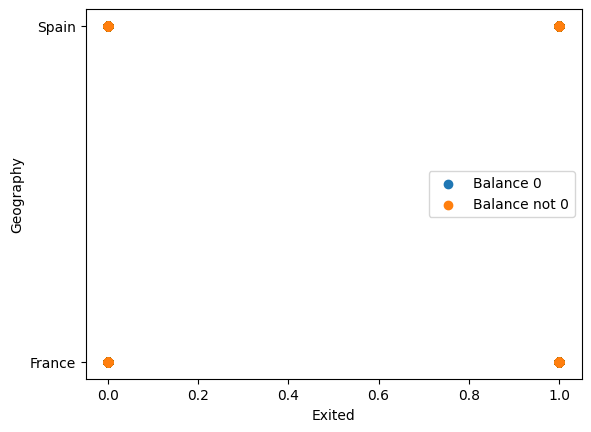

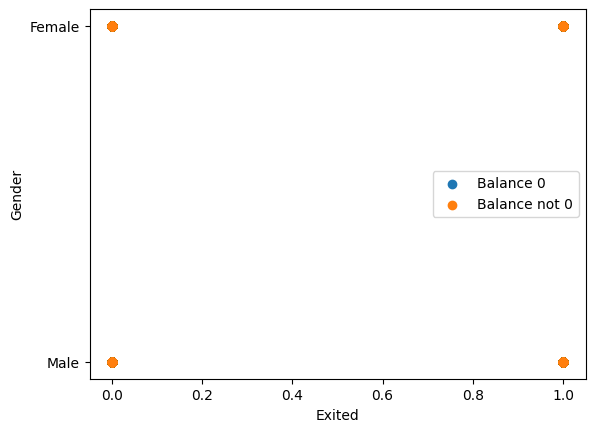

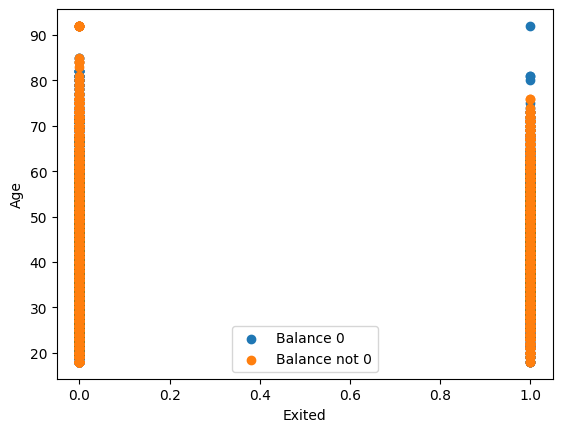

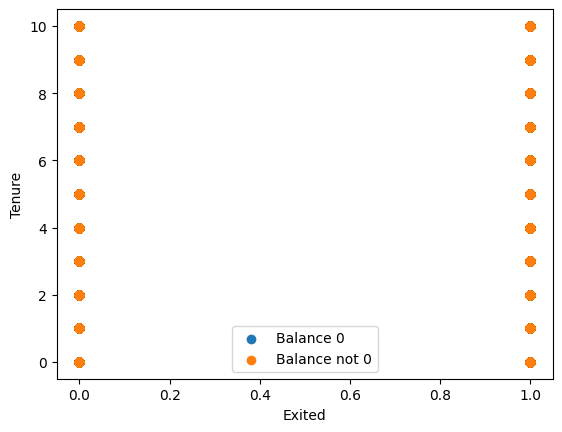

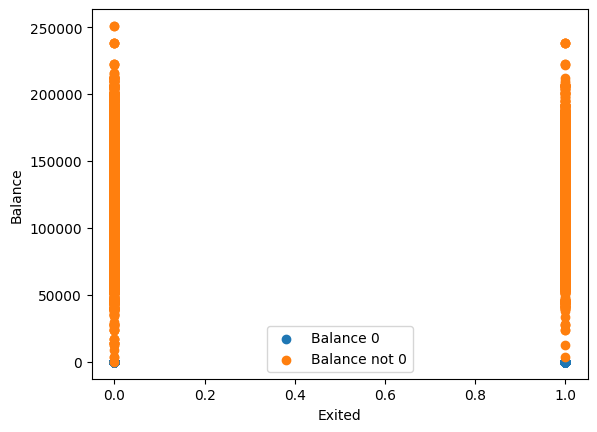

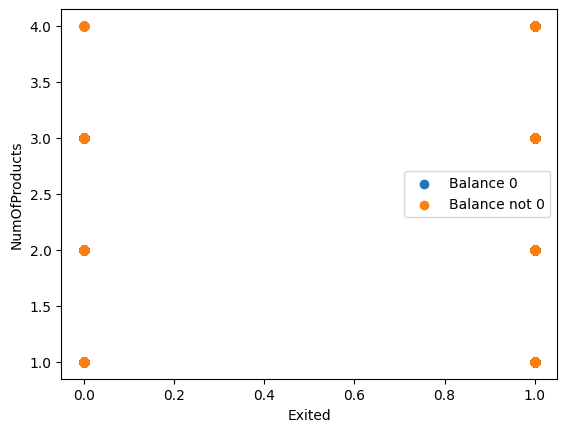

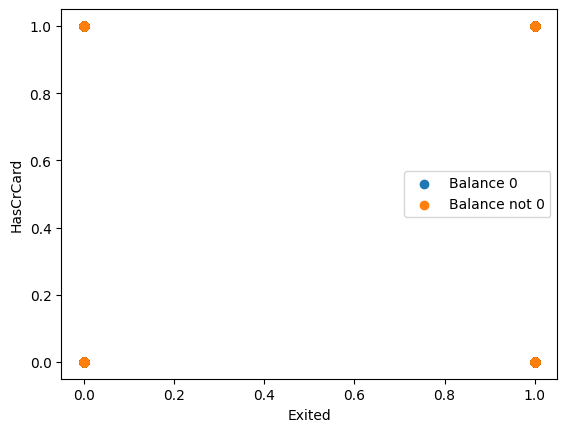

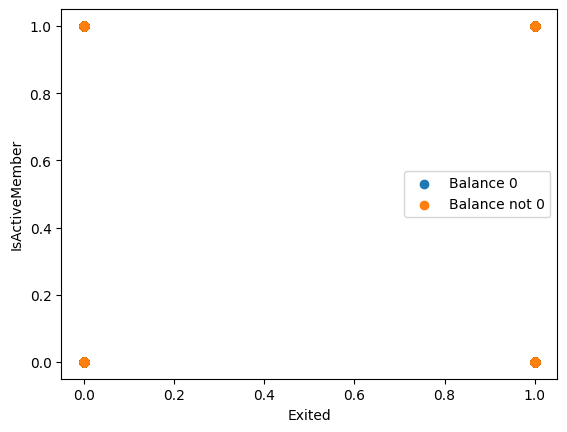

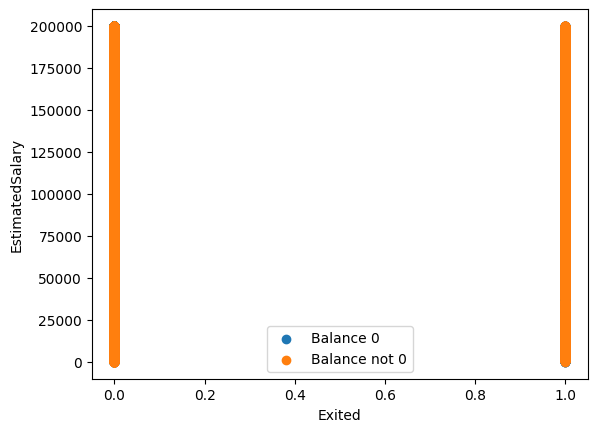

In [18]:
selection_dict = {"Balance 0": train_df['Balance'] == 0, "Balance not 0": train_df['Balance'] != 0}

def compare_scatter(train_df, x_var_name, y_var_name, selections, make_legend=True):
    for label, selection in selections.items():
        plt.scatter(train_df[selection][x_var_name], train_df[selection][y_var_name], label=label)

    plt.xlabel(x_var_name)
    plt.ylabel(y_var_name)

    if make_legend:
        plt.legend()

excluded_columns = ['CustomerId', 'id', 'Surname']
columns_to_compare = [col for col in train_df.columns if col not in excluded_columns]

for x_var_name in columns_to_compare:
    for y_var_name in columns_to_compare:
        if x_var_name != y_var_name:  # Avoid plotting the same variable against itself
            compare_scatter(train_df, x_var_name, y_var_name, selection_dict)
            plt.show()


### **3. Data Cleaning and Preperation for Machine Learning**

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def clean_data(df):
    # Create a copy
    df_cleaned = df.copy()

    # Handle missing values for numerical columns
    numerical_cols = df_cleaned.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

    # Handle missing values for categorical columns
    categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Handle age outliers
    age_median = df_cleaned['Age'].median()
    df_cleaned.loc[df_cleaned['Age'] < 18, 'Age'] = age_median
    df_cleaned.loc[df_cleaned['Age'] > 100, 'Age'] = age_median

    # Handle credit score outliers
    credit_score_median = df_cleaned['CreditScore'].median()
    df_cleaned.loc[df_cleaned['CreditScore'] < 300, 'CreditScore'] = credit_score_median
    df_cleaned.loc[df_cleaned['CreditScore'] > 850, 'CreditScore'] = credit_score_median

    # Handle estimated salary outliers
    salary_q3 = df_cleaned['EstimatedSalary'].quantile(0.75)
    salary_iqr = salary_q3 - df_cleaned['EstimatedSalary'].quantile(0.25)
    salary_upper = salary_q3 + 1.5 * salary_iqr
    df_cleaned['EstimatedSalary'] = df_cleaned['EstimatedSalary'].clip(lower=0, upper=salary_upper)

    # Handle Balance outliers
    balance_q3 = df_cleaned['Balance'].quantile(0.75)
    balance_iqr = balance_q3 - df_cleaned['Balance'].quantile(0.25)
    balance_upper = balance_q3 + 1.5 * balance_iqr
    df_cleaned['Balance'] = df_cleaned['Balance'].clip(lower=0, upper=balance_upper)

    # Handle tenure outliers
    tenure_median = df_cleaned['Tenure'].median()
    df_cleaned.loc[df_cleaned['Tenure'] < 0, 'Tenure'] = tenure_median

    # Drop unnecessary columns, preserving 'Exited' if it exists
    columns_to_drop = ['CustomerId', 'Surname', 'id']
    existing_columns = [col for col in columns_to_drop if col in df_cleaned.columns]
    df_cleaned = df_cleaned.drop(columns=existing_columns)

    return df_cleaned

def prepare_features(df):
    # Separate numerical and categorical features
    categorical_features = ['Geography', 'Gender']
    numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance',
                         'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                         'EstimatedSalary']

    return categorical_features, numerical_features

def scale_features(df_train, df_test, numerical_features, scaling_strategy='standard'):
    if scaling_strategy == 'standard':
        scaler = StandardScaler()
    elif scaling_strategy == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling strategy. Use 'standard' or 'minmax'.")

    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    df_train_scaled[numerical_features] = scaler.fit_transform(df_train[numerical_features])
    df_test_scaled[numerical_features] = scaler.transform(df_test[numerical_features])

    return df_train_scaled, df_test_scaled, scaler

def encode_categorical(df_train, df_test, categorical_features):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df_train[categorical_features])

    encoded_train = encoder.transform(df_train[categorical_features])
    encoded_test = encoder.transform(df_test[categorical_features])

    # Get feature names
    feature_names = encoder.get_feature_names_out(categorical_features)

    # Create encoded dataframes
    encoded_train_df = pd.DataFrame(encoded_train, columns=feature_names, index=df_train.index)
    encoded_test_df = pd.DataFrame(encoded_test, columns=feature_names, index=df_test.index)

    return encoded_train_df, encoded_test_df, encoder

def visualize_distributions(df_before, df_after, numerical_features):
    n_features = len(numerical_features)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 4*n_features))

    for idx, feature in enumerate(numerical_features):
        sns.histplot(df_before[feature], ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Before Scaling - {feature}')

        sns.histplot(df_after[feature], ax=axes[idx, 1])
        axes[idx, 1].set_title(f'After Scaling - {feature}')

    plt.tight_layout()
    plt.show()

def preprocess_data(train_df, test_df):
    # Clean data
    print("Cleaning data")
    train_df_cleaned = clean_data(train_df)
    test_df_cleaned = clean_data(test_df)

    # Prepare features
    categorical_features, numerical_features = prepare_features(train_df_cleaned)

    # Scale features
    print("Scaling numerical features")
    train_df_scaled, test_df_scaled, scaler = scale_features(
        train_df_cleaned, test_df_cleaned,
        numerical_features, scaling_strategy='standard'
    )

    # Encode categorical features
    print("Encoding categorical features")
    train_encoded, test_encoded, encoder = encode_categorical(
        train_df_cleaned, test_df_cleaned,
        categorical_features
    )

    # Combine features and target for training data
    feature_columns = list(train_df_scaled[numerical_features].columns) + list(train_encoded.columns)
    final_train_df = pd.concat([
        train_df_scaled[numerical_features],
        train_encoded
    ], axis=1)

    # Add Exited column only to training data if it exists
    if 'Exited' in train_df_cleaned.columns:
        final_train_df['Exited'] = train_df_cleaned['Exited']

    # Combine features for test data
    final_test_df = pd.concat([
        test_df_scaled[numerical_features],
        test_encoded
    ], axis=1)

    # Visualize distributions before and after scaling
    print("Generating Visualization")
    visualize_distributions(
        train_df_cleaned[numerical_features],
        train_df_scaled[numerical_features],
        numerical_features
    )

    return final_train_df, final_test_df, scaler, encoder

Cleaning data
Scaling numerical features
Encoding categorical features
Generating Visualization


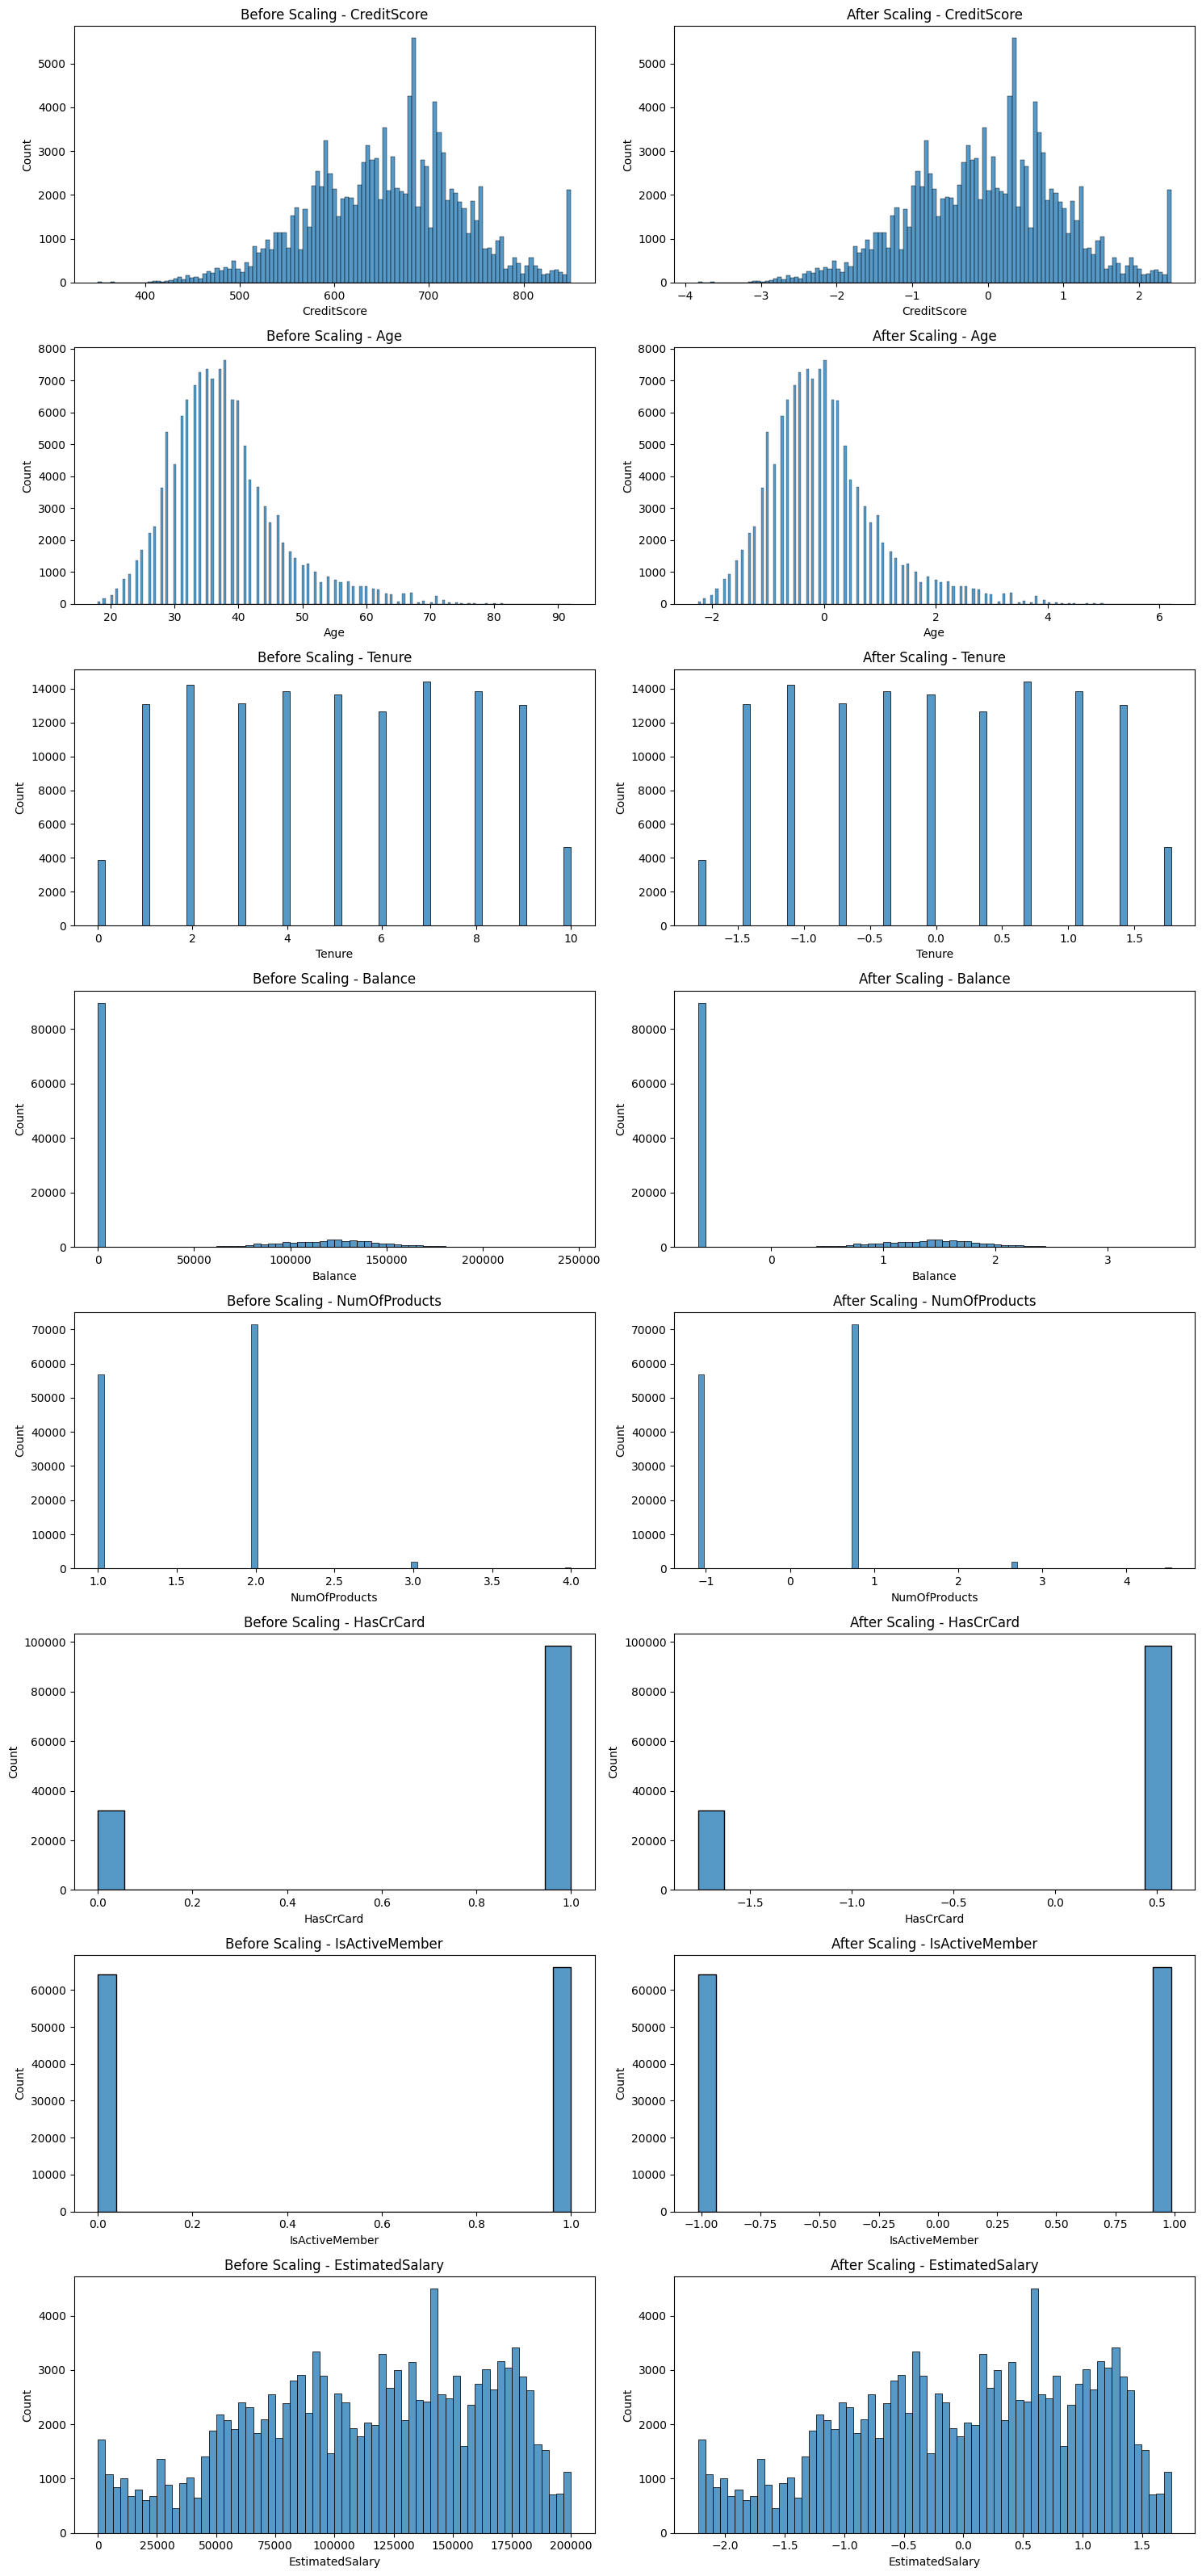

In [20]:
final_train_df, final_test_df, scaler, encoder = preprocess_data(train_df, test_df)

In [21]:
print(final_train_df.head())

   CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0     0.146093 -0.537703 -0.726641 -0.652387       0.780735   0.569559   
1    -0.367207 -0.537703 -1.441995 -0.652387       0.780735   0.569559   
2     0.271289  0.263049  1.777097 -0.652387       0.780735   0.569559   
3    -0.943106 -0.423310 -1.084318  1.901573      -1.093754   0.569559   
4     0.747031 -0.537703 -0.011287 -0.652387       0.780735   0.569559   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Spain  \
0       -1.014411         1.374705               1.0              0.0   
1        0.985794        -1.245757               1.0              0.0   
2       -1.014411         1.442561               1.0              0.0   
3        0.985794        -0.549516               1.0              0.0   
4        0.985794        -1.929631               0.0              1.0   

   Gender_Female  Gender_Male  Exited  
0            0.0          1.0       0  
1            0.0          1.0       

### **4. Machine Learning**

#### **Problem Formulation**

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def formulate_problem(df, target_column, categorical_columns=None, test_size=0.2, val_size=0.2):
    df = df.copy()

    # Drop duplicate rows
    print("Removing duplicate rows")
    df = df.drop_duplicates()

    # Drop categorical columns if specified
    if categorical_columns:
        print(f"Dropping categorical columns: {categorical_columns}")
        df = df.drop(columns=categorical_columns)

    # Ensure the target is properly encoded
    print("Encoding target column")
    label_encoder = LabelEncoder()
    df[target_column] = label_encoder.fit_transform(df[target_column])

    # Split into train/test
    print(f"Splitting data: Test size = {test_size}")
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df[target_column])

    # Split train into train/validation
    print(f"Splitting training data into train/validation: Validation size = {val_size}")
    val_size_adjusted = val_size / (1 - test_size)
    train_df, val_df = train_test_split(train_df, test_size=val_size_adjusted, random_state=42, stratify=train_df[target_column])

    print("Data split complete.")
    return train_df, val_df, test_df, label_encoder


In [23]:
# Specify the target and columns to drop
target_column = 'Exited'  # Example: target variable
categorical_columns = ['Geography', 'Gender']

# Preprocessed data from earlier steps
train_df_cleaned, test_df_cleaned = clean_data(train_df), clean_data(test_df)

# Formulate the problem
train_df, val_df, test_df, label_encoder = formulate_problem(
    train_df_cleaned, target_column,
    categorical_columns=categorical_columns
)

# Display dataset shapes
print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Removing duplicate rows
Dropping categorical columns: ['Geography', 'Gender']
Encoding target column
Splitting data: Test size = 0.2
Splitting training data into train/validation: Validation size = 0.2
Data split complete.
Train set shape: (78194, 9)
Validation set shape: (26065, 9)
Test set shape: (26065, 9)



Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
Accuracy: 0.859
ROC-AUC: 0.797

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     21704
           1       0.72      0.25      0.37      4361

    accuracy                           0.86     26065
   macro avg       0.80      0.62      0.65     26065
weighted avg       0.84      0.86      0.83     26065


Training Random Forest...

Random Forest Results:
Accuracy: 0.880
ROC-AUC: 0.869

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     21704
           1       0.71      0.47      0.57      4361

    accuracy                           0.88     26065
   macro avg       0.81      0.72      0.75     26065
weighted avg       0.87      0.88      0.87     26065


Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Accuracy: 0.885
ROC-AUC: 0.881

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     21704
           1       0.73      0.49      0.59      4361

    accuracy                           0.88     26065
   macro avg       0.82      0.73      0.76     26065
weighted avg       0.88      0.88      0.88     26065



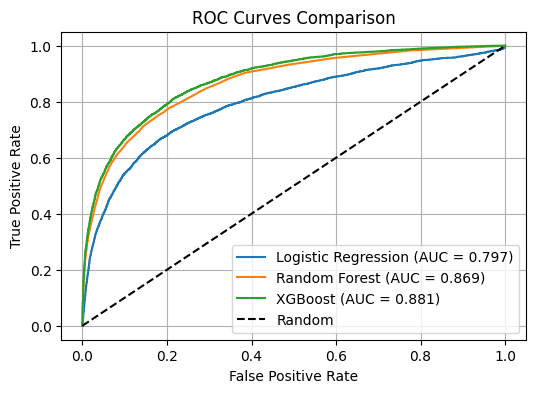


Model Comparison Summary:
                     Accuracy   ROC-AUC
XGBoost              0.884519  0.881485
Random Forest        0.879839  0.868697
Logistic Regression  0.858776  0.797193


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract features (X) and target (y)
def extract_features_and_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

# Prepare train, validation, and test datasets
X_train, y_train = extract_features_and_target(train_df, target_column)
X_val, y_val = extract_features_and_target(val_df, target_column)
X_test, y_test = extract_features_and_target(test_df, target_column)

def train_and_evaluate_models(X_train, X_val, y_train, y_val):
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    }

    results = {}

    # Train and evaluate each model
    plt.figure(figsize=(6, 4))

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        roc_auc = roc_auc_score(y_val, y_val_prob)

        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'predictions': y_val_pred,
            'probabilities': y_val_prob
        }

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_val_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

        # Print metrics
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"ROC-AUC: {roc_auc:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_val_pred))

    # Finalize ROC curve plot
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare models
    print("\nModel Comparison Summary:")
    comparison_df = pd.DataFrame({
        'Accuracy': [results[model]['accuracy'] for model in results],
        'ROC-AUC': [results[model]['roc_auc'] for model in results]
    }, index=results.keys())

    print(comparison_df.sort_values('ROC-AUC', ascending=False))

    return results, comparison_df

# Train and evaluate all models
results, comparison_df = train_and_evaluate_models(X_train, X_val, y_train, y_val)

In [25]:
# Read the original test file to get IDs
original_test = pd.read_csv('/content/data/test.csv')
customer_ids = original_test['CustomerId'].values

# Get the features that were used in training
training_features = X_train.columns.tolist()

# Make sure final_test_df has the same features in the same order
final_test_df_aligned = final_test_df[training_features]

# Get the best performing model (XGBoost from the results)
best_model = results['XGBoost']['model']

# Make predictions on the aligned test set
test_predictions = best_model.predict(final_test_df_aligned)
test_probabilities = best_model.predict_proba(final_test_df_aligned)[:, 1]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'CustomerId': customer_ids,
    'Exited': test_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Display first few rows of the submission file
print("\nFirst few rows of the submission file:")
print(submission_df.head())


First few rows of the submission file:
   CustomerId  Exited
0    15773898       1
1    15782418       1
2    15807120       1
3    15808905       0
4    15607314       0
